In [154]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import sys
import re

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider, RadioButtons
import ipywidgets as widgets

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import train_utils
importlib.reload(train_utils)
import vis
importlib.reload(vis)

from sklearn.decomposition import PCA
import torch

import geomstats.visualization as visualization

from geomstats.geometry.euclidean_space import EuclideanSpace
from geomstats.geometry.discretized_curves_space import DiscretizedCurvesSpace
from geomstats.geometry.hyperbolic_space import HyperbolicSpace
from geomstats.geometry.hypersphere import Hypersphere

sns.set()

R2 = EuclideanSpace(dimension=2)
R3 = EuclideanSpace(dimension=3)
H2 = HyperbolicSpace(dimension=2)
S2 = Hypersphere(dimension=2)


DEVICE = 'cuda'
ALGO_COLOR_DICT = {'vae': 'red', 'iwae': 'orange', 'vem': 'blue', 'vem_02': 'darkblue'}
VIS_DICT = {'s2': 'S2', 'h2': 'H2_poincare_disk'}
MANIFOLD = {'r2': R2, 's2': S2, 'h2': H2}

#sys.stdout = open(os.devnull, 'w')

VAE_TYPE_COLOR_DICT = {
    'vae': 'C0',
    'vae_proj': 'C1',
    'pga': 'C3',
    'gvae': 'C4',
    'gvae_tgt': 'darkgreen'
}

N_MARKERS_DICT = {
    '10k': 's',
    '100k': 'o'
}

# Decide on experiment's configuration

In [2]:
W_TRUE, B_TRUE, NONLINEARITY = (
 {0: [[3.0], [-2.0]],
  1: [[.05, -.05], [-.15, -.1]]},
 {0: [1.0, 3.0], 
  1: [0.062, 0.609]},
 'softplus')


@interact(
    w0_00=FloatSlider(min=-3,max=3,step=1,value=W_TRUE[0][0][0]), 
    w0_01=FloatSlider(min=-3,max=3,step=1,value=W_TRUE[0][1][0]),
    b0_00=FloatSlider(min=-3,max=3,step=1,value=B_TRUE[0][0]),
    b0_01=FloatSlider(min=-3,max=3,step=1,value=B_TRUE[0][1]),
    w1_00=FloatSlider(min=-3,max=3,step=1,value=W_TRUE[1][0][0]), 
    w1_01=FloatSlider(min=-3,max=3,step=1,value=W_TRUE[1][0][1]),
    w1_10=FloatSlider(min=-3,max=3,step=1,value=W_TRUE[1][1][0]), 
    w1_11=FloatSlider(min=-3,max=3,step=1,value=W_TRUE[1][1][1]),
    b1_00=FloatSlider(min=-3,max=3,step=0.00001,value=B_TRUE[1][0]),
    b1_01=FloatSlider(min=-3,max=3,step=0.00001,value=B_TRUE[1][1]),
    nonlinearity=RadioButtons(
        options=[None, 'relu', 'softplus', 'tanh', 'sigmoid'],
        value='softplus',
        description='Non linearity:',
        disabled=False))
def display_data(w0_00, w0_01, b0_00, b0_01, 
                 w1_00, w1_01, w1_10, w1_11, b1_00, b1_01, nonlinearity):
    W_TRUE = {}
    B_TRUE = {}

    W_TRUE[0] = [[w0_00], [w0_01]]
    B_TRUE[0] = [b0_00, b0_01]

    # For the reconstruction
    W_TRUE[1] = [[w1_00, w1_01], [w1_10, w1_11]]
    B_TRUE[1] = [b1_00, b1_01]

    decoder_true = toynn.make_decoder_true(
        w_true=W_TRUE, b_true=B_TRUE, latent_dim=1, 
        data_dim=2, n_layers=2,
        nonlinearity=nonlinearity, with_biasx=True, with_logvarx=False)

    true_x_novarx = toynn.generate_from_decoder_fixed_var(
        decoder_true, n_samples=30000, logvarx=-100)
    true_x = toynn.generate_from_decoder_fixed_var(
        decoder_true, n_samples=30000, logvarx=-5)

    fig, ax = plt.subplots()
    ax = vis.plot_data(true_x, color='green', label='from decoder true', ax=ax)
    ax = vis.plot_data(true_x_novarx, color='lime', label='from decoder true', ax=ax)
    mean = np.mean(true_x_novarx, axis=0)
    print(mean)
    ax.plot(mean[0], mean[1], color='red', markersize=10, marker='o')
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1.5, 0.5))
    ax.axis('equal')
    return W_TRUE, B_TRUE, nonlinearity

interactive(children=(FloatSlider(value=3.0, description='w0_00', max=3.0, min=-3.0, step=1.0), FloatSlider(va…

# Save parameters

In [50]:
# Divided by 20 to avoid warps
W_TRUE, B_TRUE, NONLINEARITY = (
 {0: [[3.0], [-2.0]],
  1: [[.05, -.05], [-.15, -.1]]},
 {0: [1.0, 3.0], 
  1: [0.062, 0.609]},
 'softplus')

LATENT_DIM = 1
DATA_DIM = 2
N_DECODER_LAYERS = 2
WITH_BIASX = True
WITH_BIASZ = True
WITH_LOGVARX = False  # Variance is 1 by default during learning
WITH_LOGVARZ = True

DECODER_TRUE = toynn.make_decoder_true(
            w_true=W_TRUE, b_true=B_TRUE,
            latent_dim=LATENT_DIM, data_dim=DATA_DIM,
            n_layers=N_DECODER_LAYERS,
            nonlinearity=NONLINEARITY,
            with_biasx=WITH_BIASX, with_logvarx=WITH_LOGVARX)

In [187]:
def plot_from_decoder(decoder_true, n_samples, manifold_name, logvarx=-5, ax=None):
    if manifold_name == 'r2':
        mux_riem = toynn.generate_from_decoder_fixed_var(
             decoder_true, logvarx=-1000, n_samples=n_samples)

        generated_x = toynn.generate_from_decoder_fixed_var(
             decoder_true, logvarx=logvarx, n_samples=n_samples)

        vis.plot_data(mux_riem, ax=ax, color='lime', alpha=1, s=40)
        vis.plot_data(generated_x, ax=ax, color='green', alpha=0.3)
           
    else:
        
        mux_riem = toynn.generate_from_decoder_fixed_var_riem(
            decoder_true, logvarx=-1000, n_samples=n_samples, manifold_name=manifold_name)

        generated_x = toynn.generate_from_decoder_fixed_var_riem(
            decoder_true, logvarx=logvarx, n_samples=n_samples, manifold_name=manifold_name)
        
        visualization.plot(mux_riem, ax=ax, space=VIS_DICT[manifold_name], color='lime', alpha=1, s=20)

        visualization.plot(generated_x, ax=ax, space=VIS_DICT[manifold_name], color='green', alpha=0.3)

# Plot linear / geodesic submanifold

In [4]:
#TODO

# Plot non-linear / non-geodesic submanifold

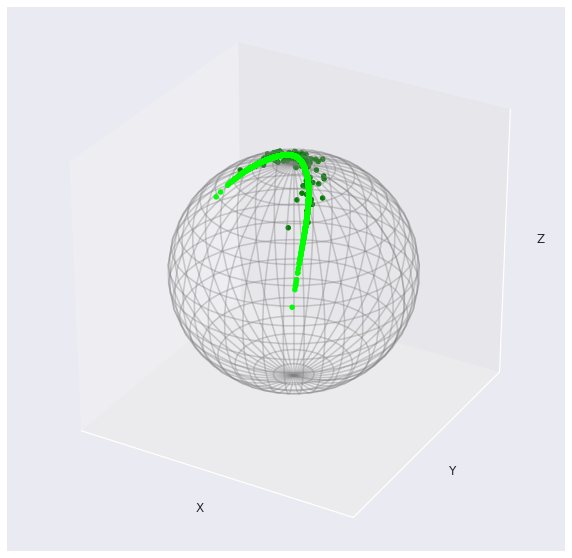

In [224]:
%matplotlib inline

manifold_name = 's2'

figsize = (8, 8)
if manifold_name == 's2':
    figsize = (10, 10)
fig = plt.figure(figsize=figsize)

if manifold_name == 's2':
    ax = fig.add_subplot(111, projection='3d')
else:
    ax = fig.add_subplot(111)

#ax = plot_from_decoder(DECODER_TRUE, n_samples, manifold_name, logvarx=-5, ax=ax)
if manifold_name == 's2' or manifold_name == 'h2':
    mux_riem = toynn.generate_from_decoder_fixed_var_riem(
            DECODER_TRUE, logvarx=-1000, n_samples=10000, manifold_name=manifold_name)
    ax = visualization.plot(
        mux_riem, ax=ax, space=VIS_DICT[manifold_name], color='lime', alpha=1, s=20,
    label='True weighted submanifold')
    mux_riem = toynn.generate_from_decoder_fixed_var_riem(
            DECODER_TRUE, logvarx=-5, n_samples=100, manifold_name=manifold_name)
    ax = visualization.plot(
        mux_riem, ax=ax, space=VIS_DICT[manifold_name], color='green', alpha=1, s=20,
    label='Data')
else:
    mux_riem = toynn.generate_from_decoder_fixed_var(
            DECODER_TRUE, logvarx=-1000, n_samples=10000)
    _ = ax.scatter(mux_riem[:, 0], mux_riem[:, 1], color='lime', alpha=1, s=30,
                   label='True weighted submanifold')
    mux_riem = toynn.generate_from_decoder_fixed_var(
            DECODER_TRUE, logvarx=-5, n_samples=100)
    _ = ax.scatter(mux_riem[:, 0], mux_riem[:, 1], color='green', alpha=1, s=30,
                   label='Data')


if manifold_name != 'r2':
    ax.set_xticks([])
    ax.set_yticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])


if manifold_name == 's2':
    ax.set_zticks([])
    
if manifold_name == 'h2':
    ax.set_xlabel('')
    ax.set_ylabel('')
#ax.legend(fontsize=20)
plt.show()

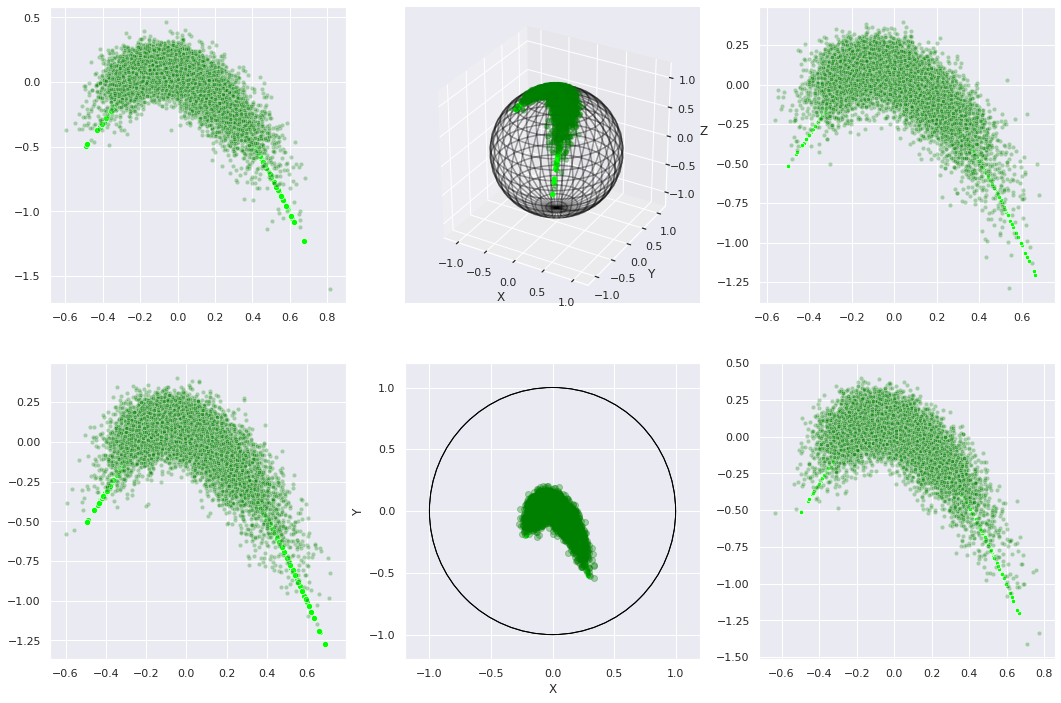

In [6]:
%matplotlib inline

fig = plt.figure(figsize=(18, 12))

logvarx = -5
n_samples = 10000
_, x, _ = DECODER_TRUE.generate(n_samples)
x = x.detach().cpu().numpy()

# First Line
ax = fig.add_subplot(231)
manifold_name = 'r2'
plot_from_decoder(DECODER_TRUE, n_samples, manifold_name, ax=ax)

ax = fig.add_subplot(232, projection='3d')
manifold_name = 's2'
plot_from_decoder(DECODER_TRUE, n_samples, manifold_name, ax=ax)

ax = fig.add_subplot(233)
manifold_name = 's2'
x_tangent = toynn.generate_from_decoder_fixed_var_tgt(
    DECODER_TRUE, logvarx=logvarx, n_samples=n_samples, manifold_name=manifold_name)
vis.plot_data(x, color='lime', ax=ax, alpha=1)
vis.plot_data(x_tangent, color='green', ax=ax, alpha=0.3)

# Second Line
ax = fig.add_subplot(234)
manifold_name = 'r2'
plot_from_decoder(DECODER_TRUE, n_samples, manifold_name, ax=ax)

ax = fig.add_subplot(235)
manifold_name = 'h2'
plot_from_decoder(DECODER_TRUE, n_samples, manifold_name, ax=ax)

ax = fig.add_subplot(236)
manifold_name = 'h2'
x_tangent = toynn.generate_from_decoder_fixed_var_tgt(
    DECODER_TRUE, logvarx=logvarx, n_samples=n_samples, manifold_name=manifold_name)

vis.plot_data(x, color='lime', ax=ax, alpha=1)
vis.plot_data(x_tangent, color='green', ax=ax, alpha=0.3)

# Inspect results from 3 pipelines

In [93]:
def get_ax_id(ncols, row_id, col_id):
    ax_id = row_id * ncols + col_id + 1
    return ax_id

In [94]:
def get_ax(fig, nrows, ncols, row_id, col_id, manifold_name='r2', tangent_space='False'):
    if manifold_name == 's2' and tangent_space is False:
        ax = fig.add_subplot(
            nrows, ncols, get_ax_id(ncols, row_id=row_id, col_id=col_id),
            projection='3d')
    else:
        ax = fig.add_subplot(nrows, ncols, get_ax_id(ncols, row_id=row_id, col_id=col_id))
    return ax

In [95]:
def load_and_plot_criterion_all(fig, nrows, ncols, row_id, col_id, output, epoch, 
                                algo_names=['vae'], crit_name='neg_elbo'):
    ax = fig.add_subplot(nrows, ncols, get_ax_id(ncols, row_id=row_id, col_id=col_id))

    for algo_name in algo_names:
        ax = load_and_plot_criterion(fig, nrows, ncols, row_id, col_id, output, epoch, 
                                     algo_name, crit_name)
    return ax

In [96]:
def load_and_plot_criterion(fig, nrows, ncols, row_id, col_id, output, epoch, 
                            algo_name='vae', crit_name='neg_elbo', ax=None):
    if ax is None:
        ax = fig.add_subplot(nrows, ncols, get_ax_id(ncols, row_id=row_id, col_id=col_id))

    train_losses = vis.load_losses(
            output, algo_name, crit_name=crit_name,
            epoch_id=int(epoch), mode='train')
    val_losses = vis.load_losses(
            output, algo_name, crit_name=crit_name,
            epoch_id=int(epoch), mode='val')    
  
    ax = vis.plot_criterion(
            ax, output, algo_name, crit_name=crit_name, 
            color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
            ax, output, algo_name, crit_name=crit_name, 
            color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, 
            color=ALGO_COLOR_DICT[algo_name])
    return ax

In [97]:
def get_output(manifold_name, logvarx, n, n_mc):
    if manifold_name == 'r2':
        output = '/scratch/users/nmiolane/toyoutput_logvarx_%d_n_%d_n_mc_iwae_10'.format(
            logvarx, n, n_mc)
    elif manifold_name == 's2':
        output = '/scratch/users/nmiolane/toyoutput_logvarx_%d_n_%d_n_mc_%d_s2'.format(
            logvarx, n, n_mc)
    elif manifold_name == 'h2':
        output = '/scratch/users/nmiolane/toyoutput_logvarx_%d_n_%d_n_mc_%d_h2'.format(
            logvarx, n, n_mc)
    return output

In [98]:
def get_toyoutput_manifold(manifold_name, logvarx, n, vae_type='gvae'):
    main_dir = '/scratch/users/nmiolane/toyoutput_manifold_%s' % vae_type
    output = os.path.join(main_dir, 'logvarx_%s_n_%d_%s' % (
            logvarx, n, manifold_name))
    return output

In [99]:
def generate_and_plot_submanifolds(fig, nrows, ncols, row_id, col_id, 
                                   output, epoch, algo_name='vae', 
                                   manifold_name='r2', tangent_space=False, n_samples=1000, ax=None):
    
    true_x, true_x_novarx, x, x_novarx = vis.generate_submanifolds(
        output, algo_name, epoch, 
        manifold_name=manifold_name, 
        tangent_space=tangent_space, 
        n_samples=n_samples)
    
    if ax is None:
        ax = get_ax(fig, nrows, ncols, row_id, col_id, 
                manifold_name, tangent_space)
    
    ax = vis.plot_submanifolds(
        ax, epoch, true_x, true_x_novarx, x, x_novarx, algo_name, 
        manifold_name=manifold_name,
        tangent_space=tangent_space)
    return ax

In [100]:
def plot_submanifold_from_decoder(decoder, manifold_name, ax=None, color='lime', s=20, label='', proj=False):
    if manifold_name == 's2' or manifold_name == 'h2':
        mux_riem = toynn.generate_from_decoder_fixed_var_riem(
            decoder, logvarx=-1000, n_samples=10000, manifold_name=manifold_name)
        if manifold_name =='h2':
            visualization.plot(mux_riem, ax=ax, space=VIS_DICT[manifold_name], color=color, alpha=1, s=s)
        else:
            ax.scatter(mux_riem[:, 0], mux_riem[:, 1], mux_riem[:, 2], color=color, alpha=1, s=s, label=label)
        
    elif manifold_name == 'r2':
        mux_riem = toynn.generate_from_decoder_fixed_var(
            decoder, logvarx=-1000, n_samples=10000)
        vis.plot_data(mux_riem, ax=ax, color=color, alpha=1, s=s)
    else: # this is r3
        mux_riem = toynn.generate_from_decoder_fixed_var(
            decoder, logvarx=-1000, n_samples=10000)
        if proj:
            norms = np.linalg.norm(mux_riem, axis=1)
            norms = np.expand_dims(norms, axis=1)
            mux_riem = mux_riem / norms
            
        ax.scatter(mux_riem[:, 0], mux_riem[:, 1], mux_riem[:, 2], color=color, alpha=1, s=s, label=label)
    return ax

# Visual goodness of fit by plotting manifolds

interactive(children=(IntSlider(value=100, description='epoch', max=101, step=10), Output()), _dom_classes=('w…

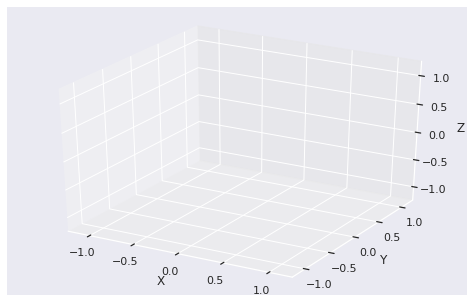

In [226]:
%matplotlib inline

@interact(
    epoch=IntSlider(min=0,max=101,step=10,value=100))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    manifold_name = 's2'
    all_logvarx_true = [-10, -5, -2]
    all_n = [10000, 50000, 100000]
    ncols = len(all_logvarx_true)
    nrows = len(all_n)
    
    if manifold_name == 'r2' or manifold_name == 'h2':
        fig = plt.figure(figsize=(18, 12))
    else:
        fig = plt.figure(figsize=(28, 18))
    
    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
            
            ax = generate_and_plot_submanifolds(
                fig, nrows, ncols, i_n, i_logvarx_true, 
                output, epoch, algo_name='vae', 
                manifold_name=manifold_name, tangent_space=False, n_samples=int(n/100))

            ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name, ax=ax, color='lime', s=5)
            
            decoder = train_utils.load_module(
                 output, algo_name='vae', module_name='decoder', epoch_id=epoch)
            ax = plot_submanifold_from_decoder(decoder, manifold_name, ax=ax, color='black', s=5)
            ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name, ax=ax, color='lime', s=5)

            
    
    sys.stdout = sys.__stdout__
    
    return epoch

In [177]:
%matplotlib inline
import matplotlib.patches as mpatches


@interact(
    epoch=IntSlider(min=0,max=290,step=1,value=290))
def display_training(epoch):
    #sys.stdout = open(os.devnull, 'w')
    
    manifold_name = 'h2'
    all_logvarx_true = [-10, -5, -2]
    all_n = [10000, 100000]
    ncols = 1 #len(all_logvarx_true)
    nrows = 1 #len(all_n)
    
    if manifold_name == 'r2' or manifold_name == 'h2':
        fig = plt.figure(figsize=(16, 8))
    else:
        fig = plt.figure(figsize=(16, 8))
        
    logvarx_true = -5
    n = 100000
    i_logvarx_true = 0
    i_n = 0
    
    output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
    decoder = train_utils.load_module(
                 output, algo_name='vae', module_name='decoder', epoch_id=epoch)

    if manifold_name == 's2':
        ax = fig.add_subplot(121, projection='3d')
    else:
        ax = fig.add_subplot(121)
        

            
    #ax = generate_and_plot_submanifolds(
    #            fig, nrows, ncols, i_n, i_logvarx_true, 
    #            output, epoch, algo_name='vae', 
    #            manifold_name=manifold_name, tangent_space=False, n_samples=0, ax=ax)

    ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name, ax=ax, color='lime', s=100)
    ax = plot_submanifold_from_decoder(decoder, manifold_name, ax=ax, color='black', s=100)
    ax.set_title('Geometric VAE at epoch %d' % epoch)
    #lime_patch = mpatches.Patch(color='lime', label='True submanifold')
    #black_patch = mpatches.Patch(color='black', label='Learned submanifold at epoch %d' % epoch)

    #plt.legend(handles=[lime_patch, black_patch], loc=3)
    
    ax = fig.add_subplot(122)

    ax = load_and_plot_criterion(
                fig, nrows, ncols, 0, 1, 
                output, epoch, 
                algo_name='vae', crit_name='neg_elbo', ax=ax)
    ax.set_ylabel('Units: nat')
    

    #ax = plot_submanifold_from_decoder(decoder, manifold_name, ax=ax, color='red', s=10)           
    
    #sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=290, description='epoch', max=290), Output()), _dom_classes=('widget-int…

<Figure size 1152x576 with 0 Axes>

In [23]:
@interact(
    epoch=IntSlider(min=0,max=299,step=10,value=290))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    manifold_name = 'r2'
    all_logvarx_true = [-10, -5, -2]
    all_n = [10000, 100000]
    ncols = len(all_logvarx_true)
    nrows = len(all_n)
    
    fig = plt.figure(figsize=(18, 12))
    
    
    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
            
            load_and_plot_criterion(
                fig, nrows, ncols, i_n, i_logvarx_true, 
                output, epoch, 
                algo_name='vae', crit_name='neg_elbo')
    
    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=290, description='epoch', max=299, step=10), Output()), _dom_classes=('w…

# Plot quantitative measures of goodness of fits

Two ways of measuring the goodness of fit for the submanifold:
- KL() ie the log-likelihood, estimated with IW
- Difference in shapes: L2Metric
--> Do they match

In [227]:
#t = np.random.normal(size=(n_samples,))
#t = np.sort(t)

def manifold_from_t(t, decoder, manifold_name):
    """
    Times t on the 1D latent space.
    Convert this into samples along the 1D manifold.
    """
    t = torch.Tensor(t).to(DEVICE)
    mux, _ = decoder(t)
    mux = mux.detach().cpu().numpy()
    
    if manifold_name == 'r2' or manifold_name == 'r3':
        return mux
    mux = toynn.convert_to_tangent_space(mux, manifold_name=manifold_name)

    manifold, base_point = toynn.manifold_and_base_point(manifold_name)
    sampled_manifold = manifold.metric.exp(mux, base_point=base_point)
    
    return sampled_manifold

In [228]:
def dist_between_manifolds(manifold_name, 
                           all_logvarx_true=[-10, -5, -3.22, -2, -1.02, -0.45, 0], 
                           all_n=[10000, 100000],
                           metric_name='l2',
                           n_samples = 1000):
    """
    Compute d(N1, N2) = \int d(f_theta1(x), f_theta2(x)) dmu(x)
    by Monte-Carlo approximation,
    when mu is the standard normal on the 1D latent space.
    """
    
    curves_space = DiscretizedCurvesSpace(
        ambient_manifold=MANIFOLD[manifold_name])
    if metric_name == 'l2':
        metric = curves_space.l2_metric
    elif metric_name == 'srv':
        metric = curves_space.square_root_velocity_metric

    badness_of_fit = np.zeros((len(all_n), len(all_logvarx_true)))

    t = np.random.normal(size=(n_samples,))
    t = np.sort(t)
    manifold_true = manifold_from_t(t, DECODER_TRUE, manifold_name)

    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n, vae_type='gvae_tgt')
            print(output)

            decoder = train_utils.load_module(
                output, algo_name='vae', module_name='decoder', epoch_id=290)
        
            manifold_learned = manifold_from_t(t, decoder, manifold_name)
   
            badness = metric.dist(
                manifold_true, manifold_learned)
            badness_of_fit[i_n, i_logvarx_true] = badness
        #print('Dist n = %d and logvarx = %d:\n' %(n, logvarx_true))
        #print(badness)
    return badness_of_fit

In [229]:
def crit_between_manifolds(manifold_name, 
                           all_logvarx_true=[-10, -5, -3.22, -2, -1.02, -0.45, 0], 
                           all_n=[10000, 100000],
                           crit_name='neg_elbo'):
    crit = np.zeros((len(all_n), len(all_logvarx_true)))

    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n, vae_type='gvae_tgt')

            val_losses = vis.load_losses(
                output, 'vae', crit_name=crit_name,
                epoch_id=int(100), mode='val')
            crit[i_n, i_logvarx_true] = val_losses[100]
    return crit

# Evaluation of goodness of fits, wrt sigma and n, for each manifold

In [104]:
def print_crit_table(ax, crit):
    im = ax.imshow(crit, cmap='Blues')
    for (j,i), label in np.ndenumerate(crit):
        ax.text(i,j,'%.2f'% label, ha='center', va='center', fontsize=15)
    ax.grid(False)
    plt.axis('off')
    return ax

def plot_crit(ax, crit, title='', vae_type='gvae_tgt'):
    ax.plot(
        ALL_STD, crit[0, :], label='n = 10k', 
        marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT[vae_type])
    ax.plot(
        ALL_STD, crit[1, :], label='n = 100k', 
        marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT[vae_type])

    ax.set_xlabel('Standard deviation', fontsize=20)
    ax.set_ylabel(title, fontsize=20)
    
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    ax.legend(fontsize=20)
    return ax

In [105]:
def plot_crits_all_manifolds(crits, title):
    fig = plt.figure(figsize=(16, 6))
    i = 1
    for manifold_name in ['r2', 's2', 'h2']:
        crit = crits[manifold_name]
        ax = fig.add_subplot(1, 3, i)
        i += 1
        ax = plot_crit(
            ax, crit, title=title + ' (%s)' % manifold_name)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    
        #if manifold_name in ['h2', 's2']:
        #    ax.plot(ALL_STD, crits['r2'][0, :], label='n = 10k', marker='s', dashes=[6, 2], color='C0')
        #    ax.plot(ALL_STD, crits['r2'][1, :], label='n = 100k', marker='s', dashes=[6, 2], color='C1')

# STD and N taken into account

In [106]:
ALL_LOGVARX_TRUE = [-10, -5, -3.22, -2, -1.02, -0.45, 0]
ALL_STD = np.sqrt(np.exp(ALL_LOGVARX_TRUE))

In [77]:
dists = {
    'r2': dist_between_manifolds(manifold_name='r2'),
    'h2': dist_between_manifolds(manifold_name='h2'),
    's2': dist_between_manifolds(manifold_name='s2')
}

/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_10000_r2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_10000_r2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_100000_r2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_100000_r2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_10000_r2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_10000_r2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_100000_r2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_100000_r2/train_vae/epoch_290_check

Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_100000_s2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_100000_s2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_10000_s2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_10000_s2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_100000_s2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_100000_s2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
/scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-2_n_10000_s2
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_mani

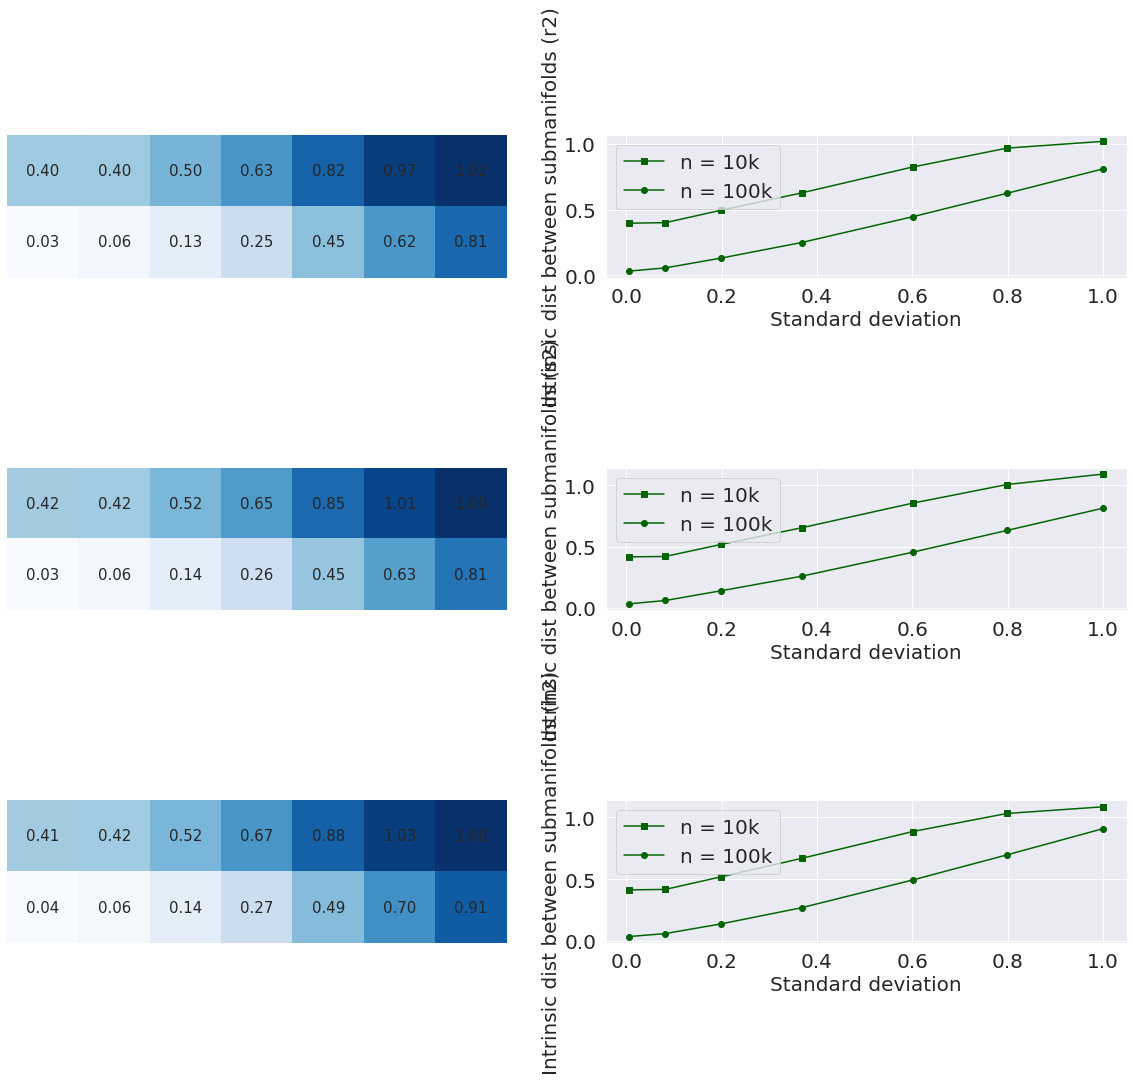

In [151]:
fig = plt.figure(figsize=(16, 14))

i = 1
for manifold_name in ['r2', 's2', 'h2']:
    dist = dists[manifold_name]
    ax = fig.add_subplot(3, 2, i)
    i += 1
    ax = print_crit_table(ax, dist)
    ax = fig.add_subplot(3, 2, i)
    i += 1
    ax = plot_crit(
    ax, dist, title='Intrinsic dist between submanifolds (%s)' % manifold_name)
plt.tight_layout()

    #if manifold_name in ['h2', 's2']:
        #ax.plot(ALL_STD, dists['r2'][0, :], label='n = 10k', marker='s', dashes=[6, 2], color='C0')
        #ax.plot(ALL_STD, dists['r2'][1, :], label='n = 100k', marker='s', dashes=[6, 2], color='C1')

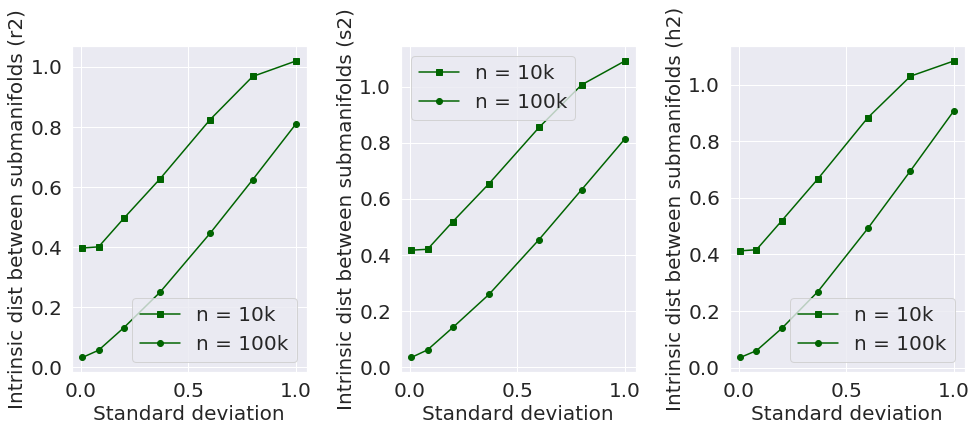

In [152]:
plot_crits_all_manifolds(dists, title='Intrinsic dist between submanifolds')

In [180]:
ots = {
    'r2': ot_between_manifolds(vae_type='gvae_tgt', manifold_name='r2', ot_manifold_name='r2'),
    'h2': ot_between_manifolds(vae_type='gvae_tgt', manifold_name='h2', ot_manifold_name='h2'),
    's2': ot_between_manifolds(vae_type='gvae_tgt', manifold_name='s2', ot_manifold_name='s2'),
}

Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_100000_r2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_100000_r2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/n

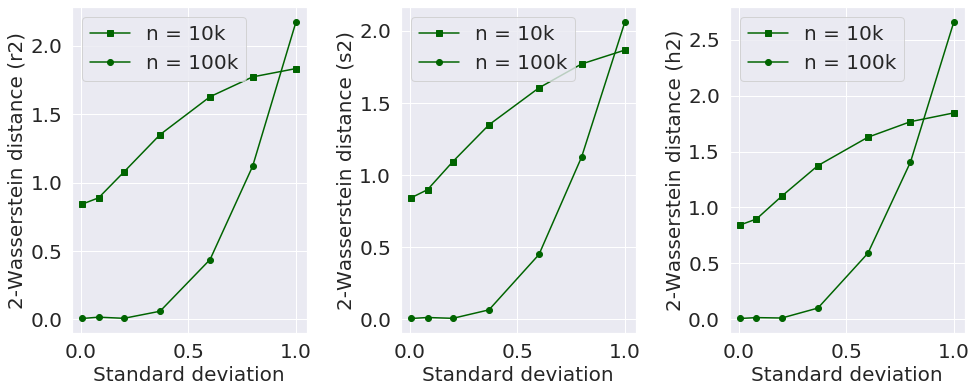

In [230]:
plot_crits_all_manifolds(ots, title='2-Wasserstein distance')

Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-10_n_100000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-5_n_100000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-3.22_n_100000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae_tgt/logvarx_-2_n_10000_r2/train_vae/epoch_100_checkpoint.pth.
Found checkpoint. Getting: /sc

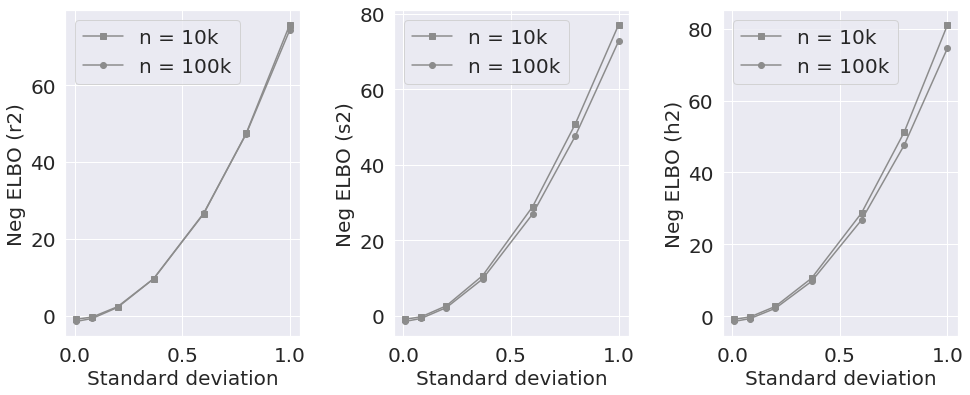

In [82]:
neg_elbos = {
    'r2': crit_between_manifolds(manifold_name='r2', crit_name='neg_elbo'),
    'h2': crit_between_manifolds(manifold_name='h2', crit_name='neg_elbo'),
    's2': crit_between_manifolds(manifold_name='s2', crit_name='neg_elbo')
}

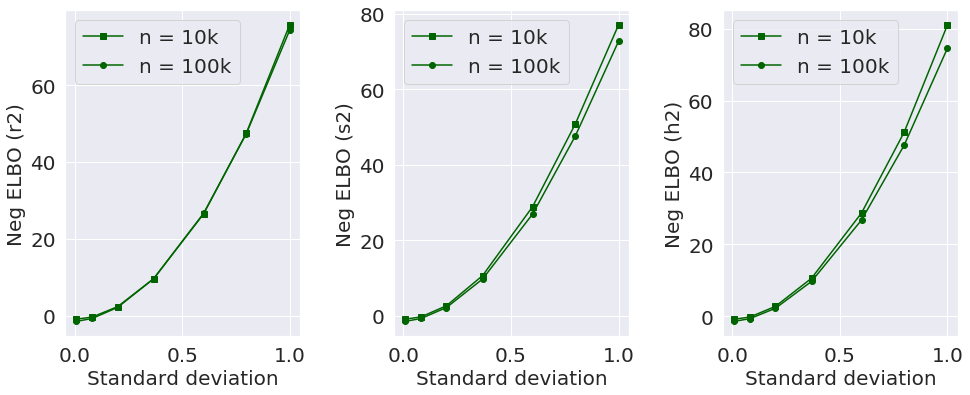

In [110]:
plot_crits_all_manifolds(neg_elbos, title='Neg ELBO')

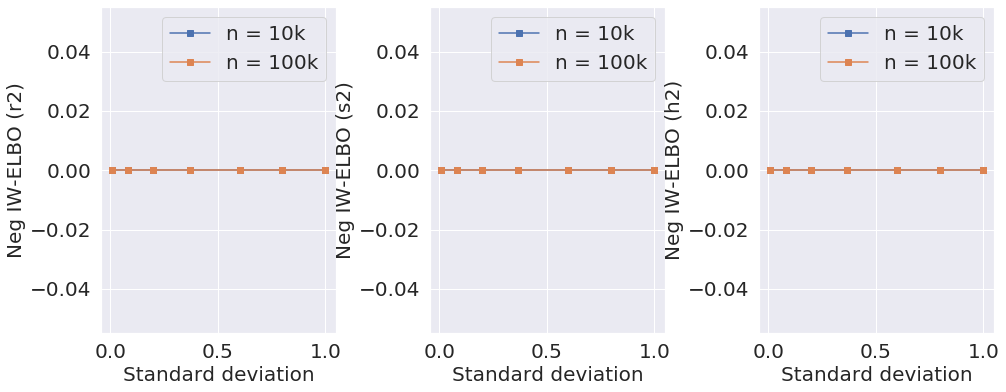

In [197]:
neg_iwelbos = {
    'r2': crit_between_manifolds(manifold_name='r2', crit_name='neg_iwelbo'),
    'h2': crit_between_manifolds(manifold_name='h2', crit_name='neg_iwelbo'),
    's2': crit_between_manifolds(manifold_name='s2', crit_name='neg_iwelbo')
}
plot_crits_all_manifolds(neg_iwelbos, title='Neg IW-ELBO')

In [100]:
manifold_name = 'r2'
all_logvarx_true = [-10, -5, -2]
all_n = [10000, 100000]
ncols = len(all_logvarx_true)
nrows = len(all_n)
    

for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
            
            ax = generate_and_plot_submanifolds(
                fig, nrows, ncols, i_n, i_logvarx_true, 
                output, epoch, algo_name='vae', 
                manifold_name=manifold_name, tangent_space=False, n_samples=int(n/100))

            ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name, ax=ax, color='lime', s=5)
            
            decoder = train_utils.load_module(
                 output, algo_name='vae', module_name='decoder', epoch_id=epoch)

/home/user/miniconda/envs/py36/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/user/miniconda/envs/py36/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/user/miniconda/envs/py36/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Softplus' has changed. you can retrieve the original

IndexError: index 2 is out of bounds for axis 1 with size 2

# Evaluation of goodness of fit: VAE in S2 in R3, versus gVAE on S2

In [103]:
vae_dir = '/scratch/users/nmiolane/toyoutput_manifold_vae/'
gvae_dir = '/scratch/users/nmiolane/toyoutput_manifold_gvae/'

synthetic_dataset = np.load(
    vae_dir + 'logvarx_-5_n_100000_s2/synthetic/dataset.npy')

In [26]:
print(synthetic_dataset[:3])
print(np.linalg.norm(synthetic_dataset[0]))

[[-0.08498354  0.17295184  0.98125708]
 [-0.1546449   0.27256265  0.94962864]
 [ 0.1780411  -0.07571589  0.98110574]]
0.9999999980741969


## Visual inspection

In [ ]:
from geomstats.visualization import Sphere
from geomstats.geometry.discretized_curves_space import DiscretizedCurvesSpace
from geomstats.geometry.euclidean_space import EuclideanSpace

/home/user/miniconda/envs/py36/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[]

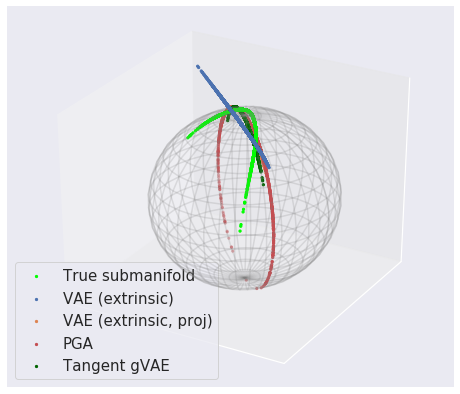

In [233]:
%matplotlib inline

sphere = Sphere()
manifold_name = 's2'

n_samples = 1000
logvarx_true = -2
n = 10000
crit_name = 'neg_elbo'
epoch_id = 100

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
sphere.draw(ax=ax)
ax = plot_submanifold_from_decoder(
    DECODER_TRUE, manifold_name, ax=ax, color='lime', s=5, label='True submanifold')

# For VAE
vae_type = 'vae'
output = get_toyoutput_manifold(
    manifold_name, logvarx_true, n, vae_type=vae_type)
decoder = train_utils.load_module(
    output, algo_name='vae', module_name='decoder', epoch_id=epoch_id)

ax = plot_submanifold_from_decoder(
    decoder, manifold_name='r3', ax=ax, 
    color=VAE_TYPE_COLOR_DICT[vae_type], s=5, label='VAE (extrinsic)')

# For VAE (proj)
vae_type = 'vae_proj'
ax = plot_submanifold_from_decoder(
    decoder, manifold_name='r3', ax=ax, 
    color=VAE_TYPE_COLOR_DICT[vae_type], s=5, label='VAE (extrinsic, proj)', proj=True)


# For PGA
vae_type = 'pga'
# Get it from gVAE tgt to have it on the tangent space for the PCA
output = get_toyoutput_manifold(manifold_name, logvarx_true, n, vae_type='gvae_tgt')
synthetic_dataset_in_tgt = np.load(os.path.join(
    output, 'synthetic/dataset.npy'))
pca = PCA(n_components=1)
pca.fit(synthetic_dataset_in_tgt)

component_extrinsic = toynn.convert_to_tangent_space(pca.components_, manifold_name='s2')


geodesic = S2.metric.geodesic(initial_point=[0, 0, 1], initial_tangent_vec=component_extrinsic)
ts = np.random.normal(size=(n_samples,))
ts = np.sort(ts)
points_on_geodesic = geodesic(ts)

ax.scatter3D(
    points_on_geodesic[:, 0], points_on_geodesic[:, 1], points_on_geodesic[:, 2], 
    color=VAE_TYPE_COLOR_DICT[vae_type], s=5, label='PGA')

# For gVAE (Tangent l2 approximation)
vae_type = 'gvae_tgt'
output = get_toyoutput_manifold(
    manifold_name, logvarx_true, n, vae_type=vae_type)
decoder = train_utils.load_module(
    output, algo_name='vae', module_name='decoder', epoch_id=epoch_id)

ax = plot_submanifold_from_decoder(
    decoder, manifold_name, ax=ax, 
    color=VAE_TYPE_COLOR_DICT[vae_type], s=5, label='Tangent gVAE')

ax.legend(fontsize=15)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

## Quantitative inspection

In [116]:
def dist_between_manifolds_in_r3(vae_type, 
                                 all_logvarx_true=[-10, -5, -3.22, -2, -1.02, -0.45, 0], 
                                 all_n=[10000, 100000],
                                 metric_name='l2',
                                 n_samples=1000,
                                 manifold_name='s2',
                                 proj=False,
                                 pga=False):
    """
    Compute d(N1, N2) = \int d(f_theta1(x), f_theta2(x)) dmu(x)
    by Monte-Carlo approximation,
    when mu is the standard normal on the 1D latent space.
    """
    epoch_id = 100
    
    curves_space = DiscretizedCurvesSpace(ambient_manifold=R3)
    if metric_name == 'l2':
        metric = curves_space.l2_metric
    elif metric_name == 'srv':
        metric = curves_space.square_root_velocity_metric

    badness_of_fit = np.zeros((len(all_n), len(all_logvarx_true)))
    t = np.random.normal(size=(n_samples,))
    t = np.sort(t)
    manifold_true = manifold_from_t(t, DECODER_TRUE, manifold_name)

    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            if pga:
                output = get_toyoutput_manifold(
                    manifold_name, logvarx_true, n, vae_type='gvae_tgt')
                synthetic_dataset_in_tgt = np.load(os.path.join(
                    output, 'synthetic/dataset.npy'))
                pca = PCA(n_components=1)
                pca.fit(synthetic_dataset_in_tgt)

                component_extrinsic = toynn.convert_to_tangent_space(
                    pca.components_, manifold_name=manifold_name)


                geodesic = S2.metric.geodesic(
                    initial_point=[0, 0, 1], 
                    initial_tangent_vec=component_extrinsic)
                manifold_learned = geodesic(t)
                
            else:
                vae_dir = '/scratch/users/nmiolane/toyoutput_manifold_%s' % vae_type
                output = os.path.join(vae_dir, 'logvarx_%s_n_%d_%s'% (logvarx_true, n, manifold_name))

                decoder = train_utils.load_module(
                    output, algo_name='vae', module_name='decoder', epoch_id=epoch_id)
        
                if vae_type == 'vae':
                    manifold_learned = manifold_from_t(
                        t, decoder, manifold_name='r3')
                elif vae_type == 'gvae_tgt':
                    manifold_learned = manifold_from_t(
                        t, decoder, manifold_name)
            
                if proj:
                    norms = np.linalg.norm(manifold_learned, axis=1)
                    norms = np.expand_dims(norms, axis=1)
                    manifold_learned = manifold_learned / norms
                    
            badness = metric.dist(
                manifold_true, manifold_learned)
            badness_of_fit[i_n, i_logvarx_true] = badness
        #print('Dist n = %d and logvarx = %d:\n' %(n, logvarx_true))
        #print(badness)
    return badness_of_fit

In [117]:
SOME_LOGVARX_TRUE = [-10, -5, -3.22, -2, -1.02] #, -0.45, 0]

dists_vae = dist_between_manifolds_in_r3(
    vae_type='vae', manifold_name='s2', all_logvarx_true=SOME_LOGVARX_TRUE)
dists_vae_proj = dist_between_manifolds_in_r3(
    vae_type='vae', manifold_name='s2', all_logvarx_true=SOME_LOGVARX_TRUE, proj=True)
dists_pga = dist_between_manifolds_in_r3(
    vae_type='vae', manifold_name='s2', all_logvarx_true=SOME_LOGVARX_TRUE, pga=True)

dists_gvae = dist_between_manifolds_in_r3(
    vae_type='gvae_tgt', manifold_name='s2', all_logvarx_true=SOME_LOGVARX_TRUE)

Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-10_n_10000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-10_n_100000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-5_n_10000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-5_n_100000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-3.22_n_10000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifol

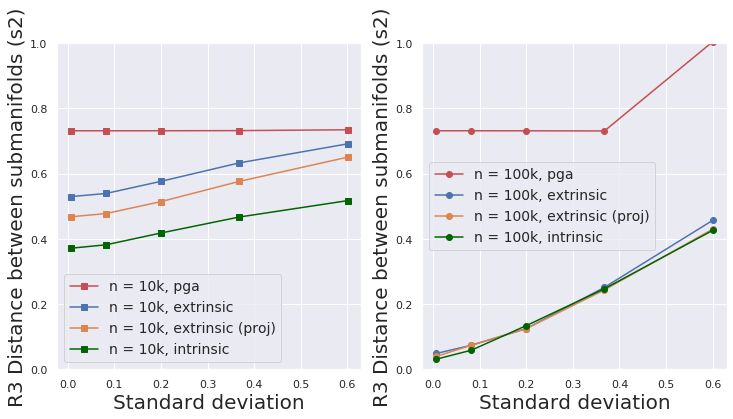

In [149]:
SOME_STD = np.sqrt(np.exp(SOME_LOGVARX_TRUE))

fig = plt.figure(figsize=(12, 6))
title='R3 Distance between submanifolds (s2)'

ax = fig.add_subplot(121)
ax.plot(
    SOME_STD, dists_pga[0, :], 
    label='n = 10k, pga', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['pga'])
ax.plot(
    SOME_STD, dists_vae[0, :], 
    label='n = 10k, extrinsic', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['vae'])

ax.plot(
    SOME_STD, dists_vae_proj[0, :], 
    label='n = 10k, extrinsic (proj)', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['vae_proj'])
ax.plot(
    SOME_STD, dists_gvae[0, :], 
    label='n = 10k, intrinsic', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['gvae_tgt'])

ax.set_xlabel('Standard deviation', fontsize=20)
ax.set_ylabel(title, fontsize=20)
ax.set_ylim((0, 1))
ax.legend(fontsize=14)

ax = fig.add_subplot(122)
ax.plot(
    SOME_STD, dists_pga[1, :], 
    label='n = 100k, pga', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['pga'])
ax.plot(
    SOME_STD, dists_vae[1, :], 
    label='n = 100k, extrinsic', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['vae'])

ax.plot(
    SOME_STD, dists_vae_proj[1, :], 
    label='n = 100k, extrinsic (proj)', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['vae_proj'])
ax.plot(
    SOME_STD, dists_gvae[1, :], 
    label='n = 100k, intrinsic', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['gvae_tgt'])

ax.set_xlabel('Standard deviation', fontsize=20)
ax.set_ylabel(title, fontsize=20)
ax.set_ylim((0, 1))
ax.legend(fontsize=14)

## Quantitative inspection with Riemannian 2-Wasserstein distance

In [127]:
import ot
from ot.datasets import make_1D_gauss as gauss
import matplotlib.pylab as pl

In [160]:
np.linspace(-2, 3, 10)

array([-2.        , -1.44444444, -0.88888889, -0.33333333,  0.22222222,
        0.77777778,  1.33333333,  1.88888889,  2.44444444,  3.        ])

In [161]:
def make_gauss_hist(n_bins, m=0, s=1):
    x_bin_min = m - 3 * s
    x_bin_max = m + 3 * s
    x = np.linspace(x_bin_min, x_bin_max, n_bins, dtype=np.float64)
    h = np.exp(-(x - m)**2 / (2 * s**2))
    return h / h.sum()

In [177]:
def ot_between_manifolds(vae_type, 
                         all_logvarx_true=[-10, -5, -3.22, -2, -1.02, -0.45, 0], 
                         all_n=[10000, 100000],
                         n_bins=5,
                         manifold_name='s2',
                         ot_manifold_name='s2',
                         proj=False,
                         pga=False):
    """
    manifold_name: the manifold around which this experiment is considered.
    ot_manifold_name: the manifold whose sq dist should be used for OT.
    - either the Riemannian metric of manifold_name
    - or the Riemannian metric of the embedding manifold of manifold_name: r3
    """
    if ot_manifold_name in ['r2', 'h2', 's2']:
        ot_manifold, ot_base_point = toynn.manifold_and_base_point(
            ot_manifold_name)
 
    if manifold_name in ['r2', 'h2', 's2']:
        manifold, base_point = toynn.manifold_and_base_point(
            manifold_name)
        
    epoch_id = 100
    ot_emd2 = np.zeros((len(all_n), len(all_logvarx_true)))
    
    x = np.arange(n_bins, dtype=np.float64)  # bin positions
    # Gaussian distributions
    a = make_gauss_hist(n_bins, m=0, s=1) # m= mean, s= std
    b = make_gauss_hist(n_bins, m=0, s=1)
    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            
            if pga:
                output = get_toyoutput_manifold(
                    manifold_name, logvarx_true, n, vae_type='gvae_tgt')
                synthetic_dataset_in_tgt = np.load(os.path.join(
                    output, 'synthetic/dataset.npy'))
                pca = PCA(n_components=1)
                pca.fit(synthetic_dataset_in_tgt)

                component_extrinsic = toynn.convert_to_tangent_space(
                    pca.components_, manifold_name=manifold_name)

                geodesic = S2.metric.geodesic(
                    initial_point=[0, 0, 1], 
                    initial_tangent_vec=component_extrinsic)
                #manifold_learned = geodesic(t)
                
            else:            
                vae_dir = '/scratch/users/nmiolane/toyoutput_manifold_%s' % vae_type
                output = os.path.join(
                    vae_dir, 'logvarx_%s_n_%d_%s'% (
                        logvarx_true, n, manifold_name))
            
                decoder = train_utils.load_module(
                        output, algo_name='vae', 
                        module_name='decoder', epoch_id=epoch_id)
            
            M2 = np.zeros((n_bins, n_bins))
            for i in range(n_bins):  # in true submanifold
                for j in range(n_bins):  # in learned submanifold
                    zi = np.expand_dims(np.expand_dims(x[i], axis=0), axis=1)
                    zi = torch.Tensor(zi).to(DEVICE)
                    xi, _ = DECODER_TRUE(zi)
                    xi = xi.detach().cpu().numpy()
                    # Decoder true sends on tgt space 2D at pole
                    xi = toynn.convert_to_tangent_space(
                        xi, manifold_name=manifold_name)
                    xi = manifold.metric.exp(
                        tangent_vec=xi, base_point=base_point)
                      
                    zj = np.expand_dims(np.expand_dims(x[j], axis=0), axis=1)
                    if pga:
                        xj = geodesic(zj)
                      
                    else:
                        zj = torch.Tensor(zj).to(DEVICE) 
                        xj, _ = decoder(zj)
                        xj = xj.detach().cpu().numpy()
                          
                        if vae_type == 'gvae_tgt':
                            xj = toynn.convert_to_tangent_space(
                                xj, manifold_name=manifold_name)
                            xj = manifold.metric.exp(
                                tangent_vec=xj, base_point=base_point)
                        
                        if proj:
                            norms = np.linalg.norm(xj, axis=1)
                            norms = np.expand_dims(norms, axis=1)
                            xj = xj / norms
                        
                    
                    if ot_manifold_name in ['r2', 's2', 'h2']:
                        sq_dist = ot_manifold.metric.squared_dist(xi, xj)
                    else:
                        sq_dist = np.linalg.norm(xj - xi) ** 2
                    M2[i, j] = sq_dist
                
            #M2 /= M2.max()
            
            d_emd2 = ot.emd2(a, b, M2)
            
            ot_emd2[i_n, i_logvarx_true] = d_emd2
    return ot_emd2

In [44]:
# Can't model the fact that it costs to stay at the same place
a=[.5,.5]
b=[.5,.5]
M=[[10.,0.],[0.,1.]]
print(ot.emd2(a,b,M))

# Can't model the fact that it costs to stay at the same place
a=[.9,.1]
b=[.9,.1]
M=[[0.,1.],[1.,0.]]
print(ot.emd2(a,b,M))

# Yes!
a=[.9,.1]
b=[.9,.1]
M=[[1.,0.],[0.,1.]]
print(ot.emd2(a,b,M))

a=[.9,.1]
b=[.9,.1]
M=[[1.,0.2],[0.2,1.]]
print(ot.emd2(a,b,M))

0.0
0.0
0.8
0.8400000000000001


In [178]:
# Needs to do OT in mathbb{R}^3 here

SOME_LOGVARX_TRUE = [-10, -5, -3.22, -2, -1.02] #, -0.45, 0]

ot_vae = ot_between_manifolds(
    vae_type='vae', manifold_name='s2', ot_manifold_name='r3', all_logvarx_true=SOME_LOGVARX_TRUE)
ot_vae_proj = ot_between_manifolds(
    vae_type='vae', manifold_name='s2', ot_manifold_name='r3', all_logvarx_true=SOME_LOGVARX_TRUE, proj=True)
ot_pga = ot_between_manifolds(
    vae_type='vae', manifold_name='s2', ot_manifold_name='r3', all_logvarx_true=SOME_LOGVARX_TRUE, pga=True)
ot_gvae = ot_between_manifolds(
    vae_type='gvae_tgt', manifold_name='s2', ot_manifold_name='r3', all_logvarx_true=SOME_LOGVARX_TRUE)

Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-10_n_10000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-10_n_100000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-5_n_10000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-5_n_100000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-3.22_n_10000_s2/train_vae/epoch_100_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifol

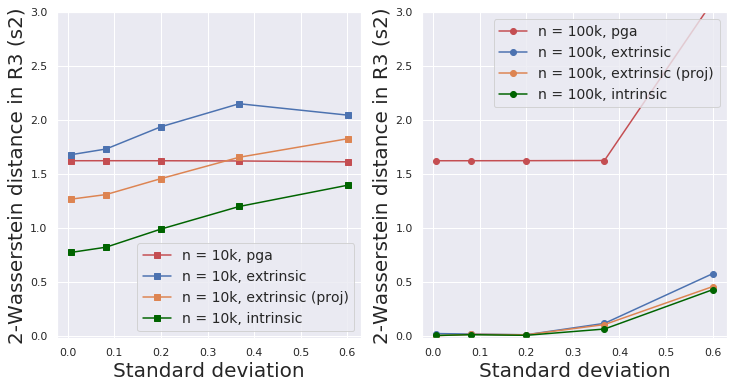

In [234]:
SOME_STD = np.sqrt(np.exp(SOME_LOGVARX_TRUE))

fig = plt.figure(figsize=(12, 6))
title='2-Wasserstein distance in R3 (s2)'

ax = fig.add_subplot(121)
ax.plot(
    SOME_STD, ot_pga[0, :], 
    label='n = 10k, pga', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['pga'])
ax.plot(
    SOME_STD, ot_vae[0, :], 
    label='n = 10k, extrinsic', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['vae'])

ax.plot(
    SOME_STD, ot_vae_proj[0, :], 
    label='n = 10k, extrinsic (proj)', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['vae_proj'])
ax.plot(
    SOME_STD, ot_gvae[0, :], 
    label='n = 10k, intrinsic', marker=N_MARKERS_DICT['10k'], color=VAE_TYPE_COLOR_DICT['gvae_tgt'])

ax.set_xlabel('Standard deviation', fontsize=20)
ax.set_ylabel(title, fontsize=20)
ax.set_ylim((-0.02, 3))
ax.legend(fontsize=14)

ax = fig.add_subplot(122)
ax.plot(
    SOME_STD, ot_pga[1, :], 
    label='n = 100k, pga', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['pga'])
ax.plot(
    SOME_STD, ot_vae[1, :], 
    label='n = 100k, extrinsic', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['vae'])

ax.plot(
    SOME_STD, ot_vae_proj[1, :], 
    label='n = 100k, extrinsic (proj)', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['vae_proj'])
ax.plot(
    SOME_STD, ot_gvae[1, :], 
    label='n = 100k, intrinsic', marker=N_MARKERS_DICT['100k'], color=VAE_TYPE_COLOR_DICT['gvae_tgt'])

ax.set_xlabel('Standard deviation', fontsize=20)
ax.set_ylabel(title, fontsize=20)
ax.set_ylim((-0.02, 3))
ax.legend(fontsize=14)

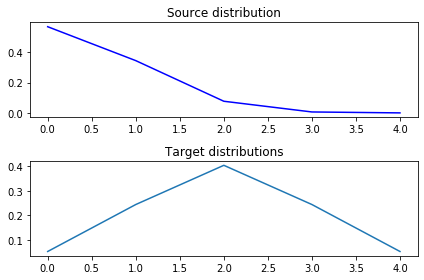

In [26]:
#%% plot the distributions
pl.figure(1)
pl.subplot(2, 1, 1)
pl.plot(x, a, 'b', label='Source distribution')
pl.title('Source distribution')
pl.subplot(2, 1, 2)
pl.plot(x, b, label='Target distributions')
pl.title('Target distributions')
pl.tight_layout()

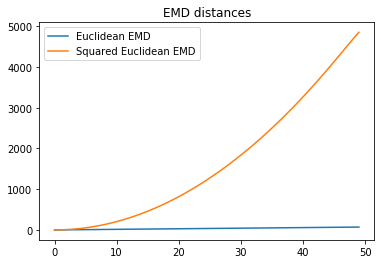

In [13]:
#%% Compute and plot distributions and loss matrix
d_emd = ot.emd2(a, B, M) # direct computation of EMD
d_emd2 = ot.emd2(a, B, M2) # direct computation of EMD with loss M2
pl.figure(2)
pl.plot(d_emd, label='Euclidean EMD')
pl.plot(d_emd2, label='Squared Euclidean EMD')
pl.title('EMD distances')
pl.legend()

Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-10_n_10000_h2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-10_n_100000_h2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-5_n_10000_h2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-5_n_100000_h2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_vae/logvarx_-3.22_n_10000_h2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifol

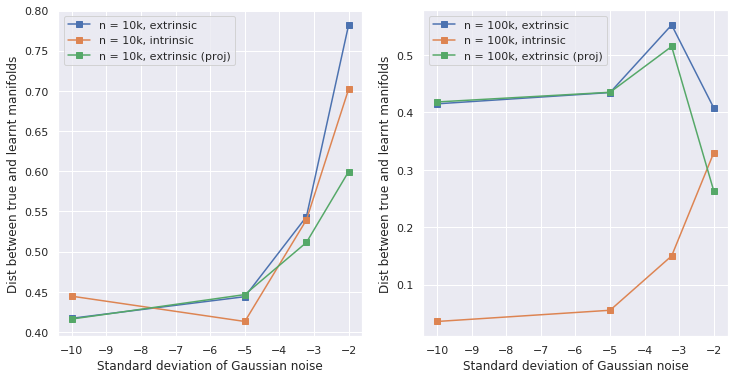

In [62]:
#H2

STDS = [-10, -5, -3.22, -2]

dists_vae = dist_between_manifolds_in_r3(
    vae_type='vae', 
    all_logvarx_true=STDS, 
    manifold_name='h2')
dists_gvae = dist_between_manifolds_in_r3(
    vae_type='gvae',
    all_logvarx_true=STDS, 
    manifold_name='h2')
dists_vae_proj = dist_between_manifolds_in_r3(
    vae_type='vae',
    all_logvarx_true=STDS, 
    manifold_name='h2', proj=True)

fig = plt.figure(figsize=(12, 6))
title='Dist between true and learnt manifolds'

ax = fig.add_subplot(121)

ax.plot(STDS, dists_vae[0, :], label='n = 10k, extrinsic', marker='s')
ax.plot(STDS, dists_gvae[0, :], label='n = 10k, intrinsic', marker='s')
ax.plot(STDS, dists_vae_proj[0, :], label='n = 10k, extrinsic (proj)', marker='s')
ax.set_xlabel('Standard deviation of Gaussian noise')
ax.set_ylabel(title)
ax.legend()

ax = fig.add_subplot(122)
ax.plot(STDS, dists_vae[1, :], label='n = 100k, extrinsic', marker='s')
ax.plot(STDS, dists_gvae[1, :], label='n = 100k, intrinsic', marker='s')
ax.plot(STDS, dists_vae_proj[1, :], label='n = 100k, extrinsic (proj)', marker='s')

ax.set_xlabel('Standard deviation of Gaussian noise')
ax.set_ylabel(title)
ax.legend()

# Comparison with PGA

In [3]:
vae_dir = '/scratch/users/nmiolane/toyoutput_manifold_vae/'
gvae_dir = '/scratch/users/nmiolane/toyoutput_manifold_gvae/'

synthetic_dataset_in_r3 = np.load(
    vae_dir + 'logvarx_-5_n_100000_s2/synthetic/dataset.npy')

synthetic_dataset_in_tgt = np.load(
    gvae_dir + 'logvarx_-5_n_100000_s2/synthetic/dataset.npy')

In [4]:
print(synthetic_dataset_in_r3[:3])
print(synthetic_dataset_in_tgt[:3])

[[-0.08498354  0.17295184  0.98125708]
 [-0.1546449   0.27256265  0.94962864]
 [ 0.1780411  -0.07571589  0.98110574]]
[[-0.0855185   0.17404055]
 [-0.15729493  0.27723334]
 [ 0.17917096 -0.07619639]]


Perform PGA by performing PCA on the data in the tangent space: the tangent space is at the origin, which is the frechet mean by construction (and also the sample frechet mean as there is a large sample size).

## Visual inspection: gVAE versus PGA

Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae/logvarx_-5_n_100000_s2/train_vae/epoch_290_checkpoint.pth.
Loading decoder from network of architecture: toy...
Found checkpoint. Getting: /scratch/users/nmiolane/toyoutput_manifold_gvae/logvarx_-5_n_100000_s2/train_vae/epoch_290_checkpoint.pth.


/home/user/miniconda/envs/py36/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


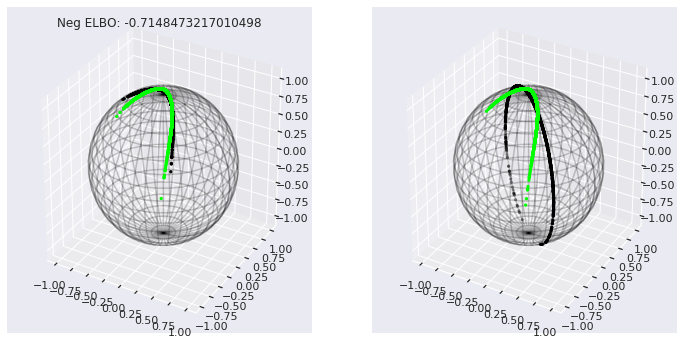

In [67]:
from geomstats.visualization import Sphere
from sklearn.decomposition import PCA


# Get data for gVAE and S2

sphere = Sphere()
manifold_name = 's2'

n_samples = 1000
logvarx_true = -5
n = 100000
crit_name = 'neg_elbo'
epoch_id = 290

fig = plt.figure(figsize=(12, 6))

# For gVAE
output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
decoder = train_utils.load_module(output, algo_name='vae', module_name='decoder', epoch_id=epoch_id)

val_losses = vis.load_losses(output, 'vae', crit_name=crit_name, epoch_id=epoch_id, mode='val')
last_val_losses = val_losses[epoch_id]

ax = fig.add_subplot(121, projection='3d')
sphere.draw(ax=ax)
ax = plot_submanifold_from_decoder(decoder, manifold_name, ax=ax, color='black', s=5)
ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name, ax=ax, color='lime', s=5)
ax.set_title('Neg ELBO: %s' % last_val_losses)

# For PGA

# Get it from gVAE to have it on the tangent space
output = get_toyoutput_manifold(manifold_name, logvarx_true, n, vae_type='gvae')
synthetic_dataset_in_tgt = np.load(os.path.join(
    output, 'synthetic/dataset.npy'))
pca = PCA(n_components=1)
pca.fit(synthetic_dataset_in_tgt)

component_extrinsic = toynn.convert_to_tangent_space(pca.components_, manifold_name='s2')

ax = fig.add_subplot(122, projection='3d')
sphere.draw(ax=ax)
ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name='s2', ax=ax, color='lime', s=5)


geodesic = S2.metric.geodesic(initial_point=[0, 0, 1], initial_tangent_vec=component_extrinsic)
ts = np.random.normal(size=(n_samples,))
ts = np.sort(ts)
points_on_geodesic = geodesic(ts)

ax.scatter3D(points_on_geodesic[:, 0], points_on_geodesic[:, 1], points_on_geodesic[:, 2], color='black', s=5)

# More plots

In [26]:
@interact(
    epoch=IntSlider(min=0,max=299,step=10,value=290))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    manifold_name = 's2'
    all_logvarx_true = [-10, -5, -2, 0]
    all_n = [50, 100, 1000, 10000, 100000]
    ncols = len(all_logvarx_true)
    nrows = len(all_n)
    
    fig = plt.figure(figsize=(18, 28))
    
    
    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
            
            generate_and_plot_submanifolds(
                fig, nrows, ncols, i_n, i_logvarx_true, 
                output, epoch, algo_name='vae', 
                manifold_name=manifold_name, tangent_space=False, n_samples=500)
    
    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=290, description='epoch', max=299, step=10), Output()), _dom_classes=('w…

In [41]:
@interact(
    epoch=IntSlider(min=0,max=299,step=10,value=290))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    manifold_name = 'r2'
    all_logvarx_true = [-10, -5, -2, 0]
    all_n = [50, 100, 1000, 10000, 100000]
    ncols = len(all_logvarx_true)
    nrows = len(all_n)
    
    fig = plt.figure(figsize=(18, 28))
    
    
    for i_logvarx_true, logvarx_true in enumerate(all_logvarx_true):
        for i_n, n in enumerate(all_n):
            output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
            
            load_and_plot_criterion(
                fig, nrows, ncols, i_n, i_logvarx_true, 
                output, epoch, 
                algo_name='vae', crit_name='neg_elbo')
    
    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=290, description='epoch', max=299, step=10), Output()), _dom_classes=('w…

<IPython.core.display.Javascript object>


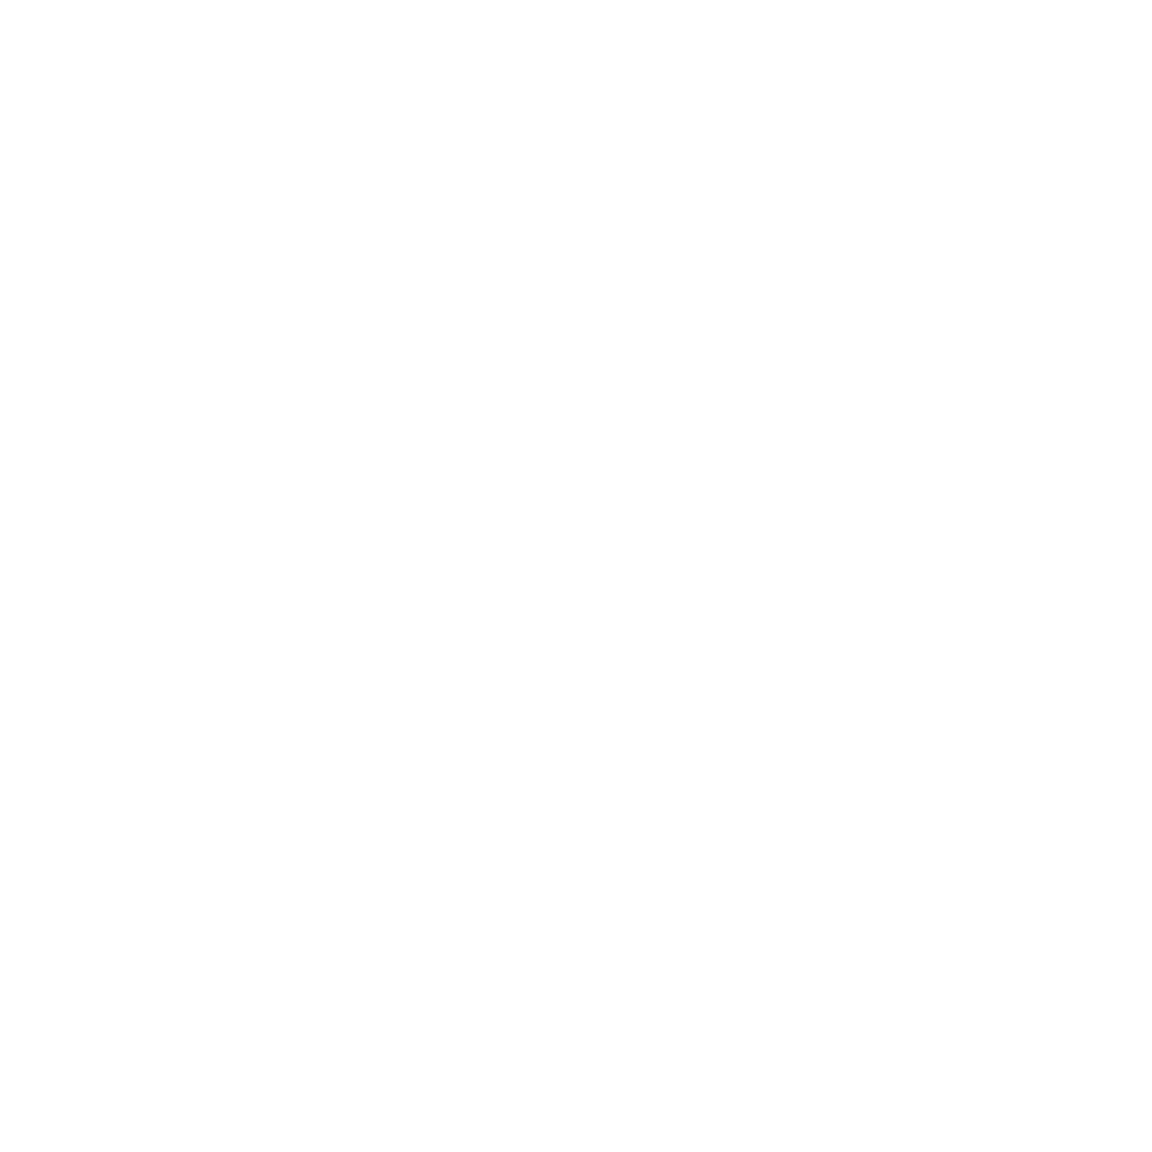

<IPython.core.display.Javascript object>


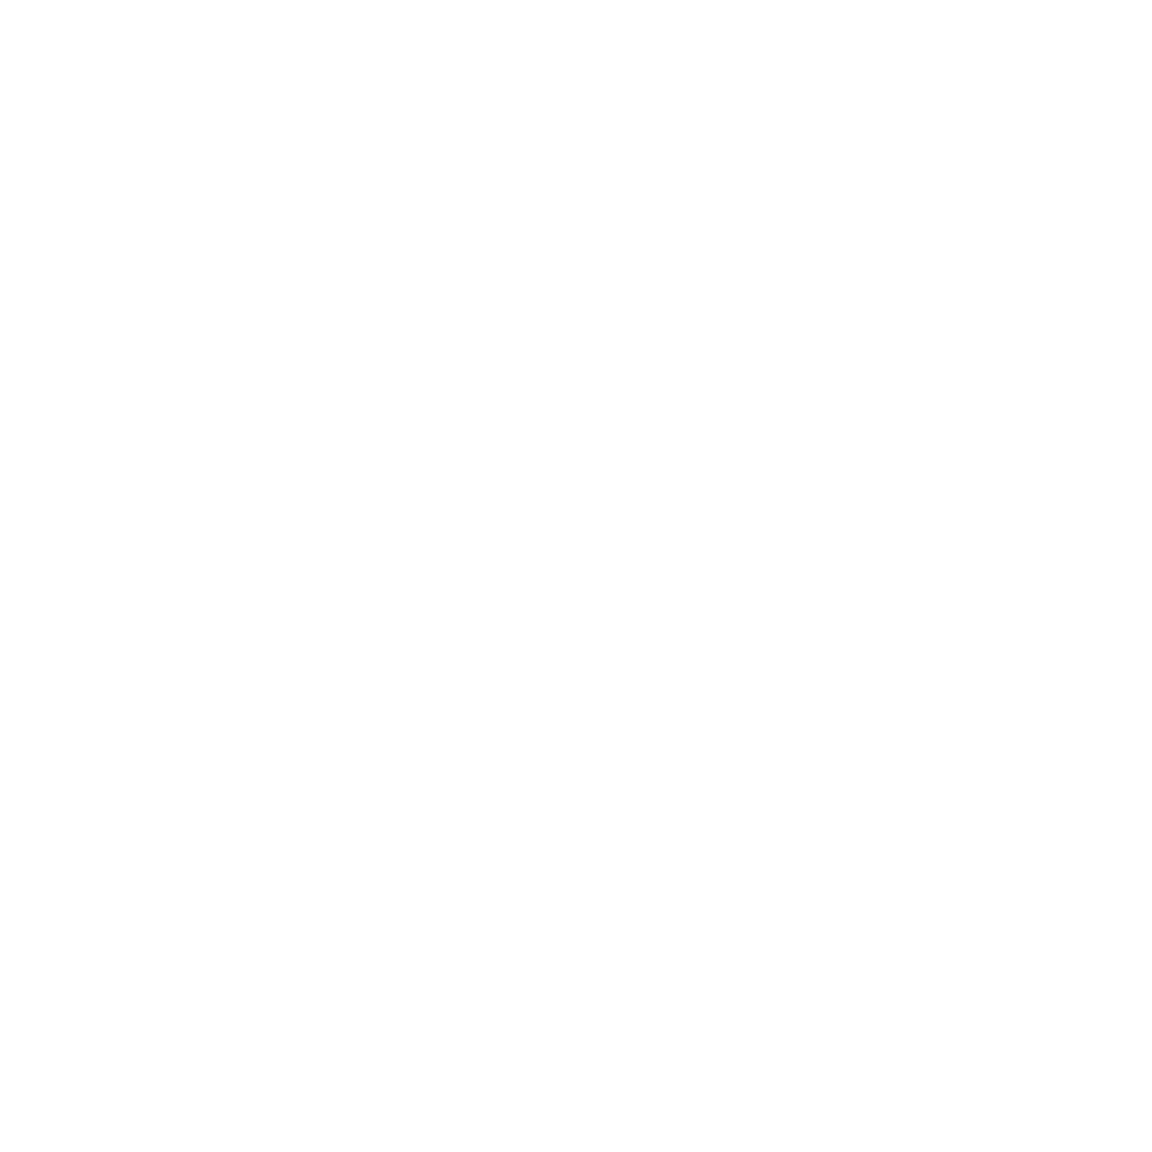

In [36]:
%matplotlib notebook
    
fig = plt.figure(figsize=(12, 12))
nrows = 1
ncols = 1
logvar_true = -5
fig.suptitle('Effect of the model\'s variance (n = 10,000 and K = 10 for IWAE).', fontsize=16)
   
output = '/scratch/users/nmiolane/toyoutput_manifold/logvarx_-5_n_10000_s2'
generate_and_plot_submanifolds(fig, nrows, ncols, 0, 0, output, epoch=290, 
              algo_name='vae', manifold_name='s2', tangent_space=False, n_samples=100)

In [16]:

@interact(
    epoch=IntSlider(min=0,max=299,step=10,value=0))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    fig = plt.figure(figsize=(12, 12))
    nrows = 1
    ncols = 1
    logvar_true = -5
    fig.suptitle('Effect of the model\'s variance (n = 10,000 and K = 10 for IWAE).', fontsize=16)
   
    output = '/scratch/users/nmiolane/toyoutput_manifold/logvarx_-10_n_1000_h2'
    generate_and_plot_submanifolds(fig, nrows, ncols, 0, 0, output, epoch, 
              algo_name='vae', manifold_name='s2', tangent_space=False, n_samples=1000)

    
    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=10), Output()), _dom_classes=('wid…

In [75]:
def print_one_logvar_col(fig, nrows, ncols, col_id, epoch, logvar_true, manifold_name='Euclidean'):
    if manifold_name == 'Euclidean':
        output = '/scratch/users/nmiolane/toyoutput_logvarx_%d_n_10000_n_mc_iwae_10' % logvar_true
    elif manifold_name == 'S2':
        output = '/scratch/users/nmiolane/toyoutput_logvarx_%d_n_10000_n_mc_10_s2' % logvar_true
    elif manifold_name == 'H2':
        output = '/scratch/users/nmiolane/toyoutput_logvarx_%d_n_10000_n_mc_10_h2' % logvar_true
    crit_name = 'neg_elbo'
    #ax = axes[0, col_id]
    #ax.set_xlabel('True log variance = %d' % logvar_true)
   # ax.xaxis.set_label_position('top') 
    
    plot_algo(fig, nrows, ncols, 0, col_id, output, epoch, 
              algo_name='vae', manifold_name=manifold_name)
    
    algo_name = 'iwae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch)
    ax = axes[1, col_id]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[2, col_id]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=10), Output()), _dom_classes=('wid…

In [76]:
def print_col(fig, nrows, ncols, epoch, col_id, output, manifold_name='r2'):
    crit_name = 'neg_elbo'
    algo_name = 'vae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch, manifold_name=manifold_name)
    
    ax = axes[0, col_id]
    ax = fig.add_subplot(1, 2, 1)
    ax = vis.plot_submanifolds(
        ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name, manifold_name=manifold_name)
    ax = axes[3, col_id]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])

    
    algo_name = 'iwae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch, manifold_name=manifold_name)
    ax = axes[1, col_id]
    ax = vis.plot_submanifolds(
        ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name, manifold_name=manifold_name)
    ax = axes[3, col_id]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])
    
        
    algo_name = 'vem'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch, manifold_name=manifold_name)
    ax = axes[2, col_id]
    ax = vis.plot_submanifolds(
        ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name, manifold_name=manifold_name)
    ax = axes[3, col_id]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])

In [77]:
def print_row(axes, epoch, row_id, output):
    crit_name = 'neg_elbo'
    algo_name = 'vae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch)
    
    ax = axes[row_id, 0]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[row_id, 4]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])

    
    algo_name = 'iwae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch)
    ax = axes[row_id, 1]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[row_id, 4]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])
        
    algo_name = 'vem'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch)
    ax = axes[row_id, 2]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[row_id, 4]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])
    
    algo_name = 'vem_02'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        output, algo_name, epoch)
    ax = axes[row_id, 3]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[row_id, 4]
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='train', dashes=False)
    ax = vis.plot_criterion(
        ax, output, algo_name, crit_name=crit_name, 
        color=ALGO_COLOR_DICT[algo_name], mode='val', dashes=True)
    ax.plot(epoch, train_losses[epoch], 'bo', markersize=10, color=ALGO_COLOR_DICT[algo_name])

In [78]:
def print_one_n_mc_col(axes, epoch, col_id, n_mc):
    output = '/scratch/users/nmiolane/toyoutput_logvarx_2_n_10000_n_mc_%d' % n_mc
    crit_name = 'neg_elbo'
    ax = axes[0, col_id]
    ax.set_xlabel('Number of MC samples = %d' % n_mc)
    ax.xaxis.set_label_position('top') 
    
    print_col(axes, epoch, col_id, output)

In [79]:
def print_one_n_mc_row(axes, epoch, row_id, n_mc):
    output = '/scratch/users/nmiolane/toyoutput_logvarx_2_n_10000_n_mc_%d' % n_mc
    crit_name = 'neg_elbo'
    ax = axes[row_id, 0]
    ax.set_ylabel('Number of MC samples = %d' % n_mc)
    
    print_row(axes, epoch, row_id, output)

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=5), Output()), _dom_classes=('widg…

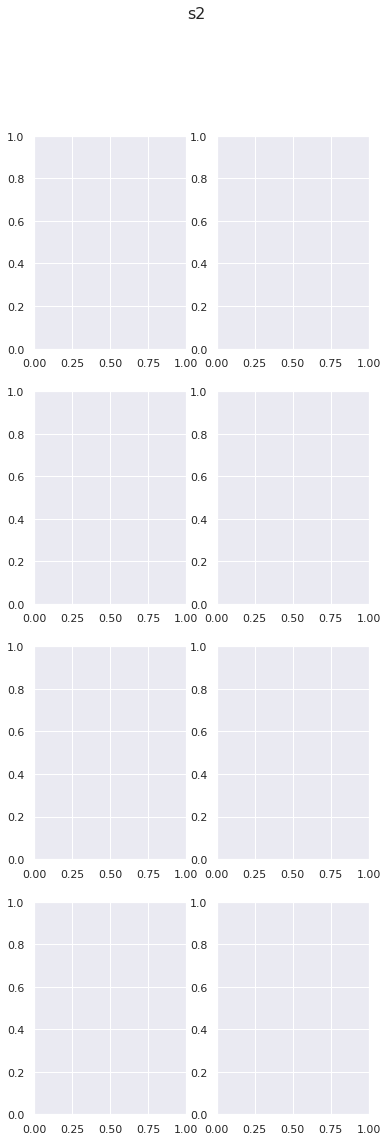

In [80]:
@interact(
    epoch=IntSlider(min=0,max=299,step=5,value=0))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 18))  
    fig.suptitle('s2', 
        fontsize=16)
    output = '/scratch/users/nmiolane/toyoutput_logvarx_-5_n_10000_n_mc_10_s2'
    print_col(axes, epoch, 0, output, manifold_name='S2')
    #fig, nrows, ncols, epoch, col_id, output, manifold_name='r2'
    
    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=5), Output()), _dom_classes=('widg…

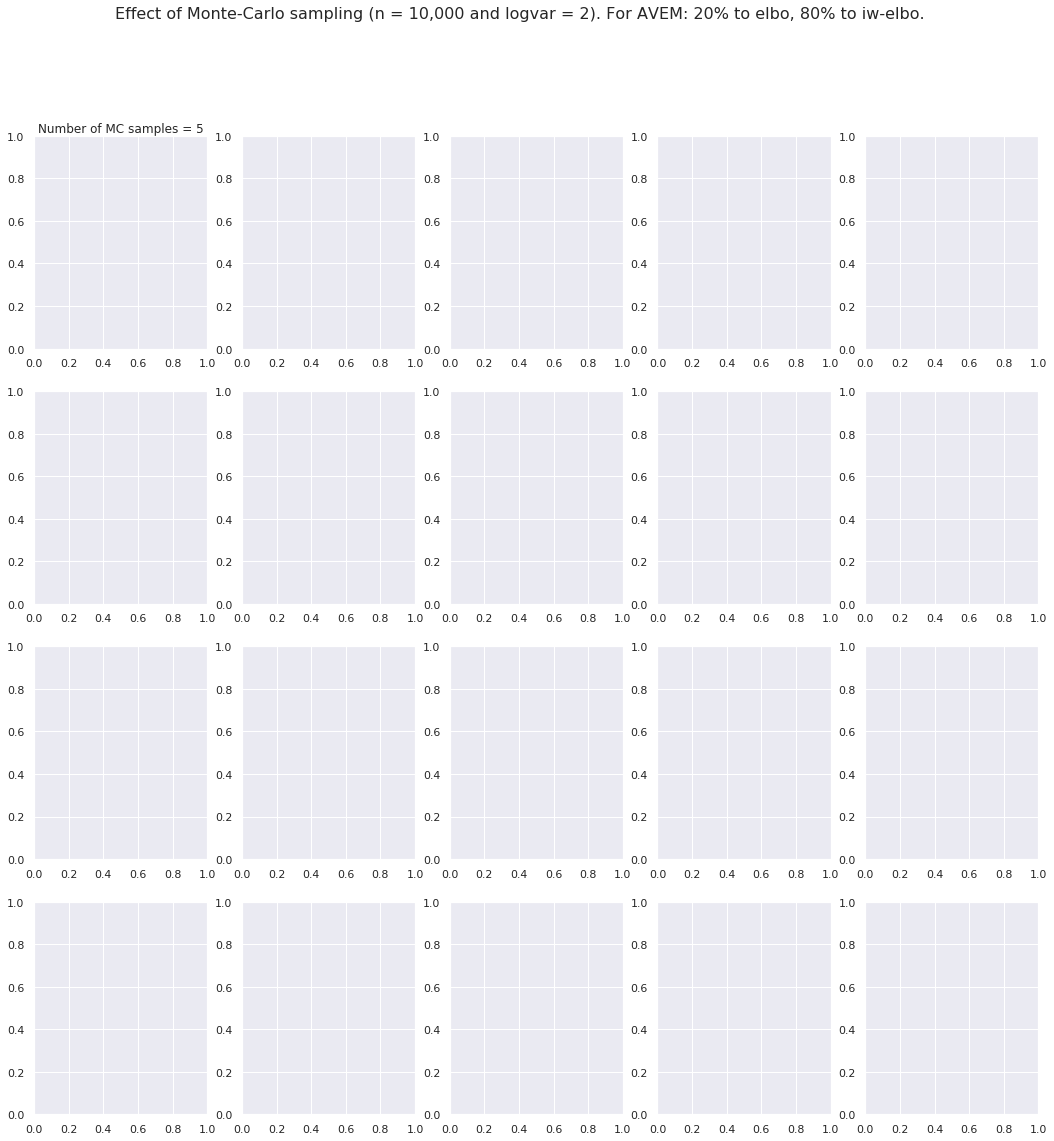

In [81]:

W_TRUE, B_TRUE, NONLINEARITY = (
 {0: [[3.0], [-2.0]],
  1: [[1.0, -1.0], [-3.0, -2.0]]},
 {0: [1.0, 3.0], 
  1: [1.0, 1.0]},
 'softplus')

@interact(
    epoch=IntSlider(min=0,max=299,step=5,value=0))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18, 18))  
    fig.suptitle(
        'Effect of Monte-Carlo sampling (n = 10,000 and logvar = 2).'
        ' For AVEM: 20% to elbo, 80% to iw-elbo.', 
        fontsize=16)
   
    print_one_n_mc_col(axes, epoch, col_id=0, n_mc=5)
    print_one_n_mc_col(axes, epoch, col_id=1, n_mc=10)
    print_one_n_mc_col(axes, epoch, col_id=2, n_mc=20)
    print_one_n_mc_col(axes, epoch, col_id=3, n_mc=100)
    print_one_n_mc_col(axes, epoch, col_id=4, n_mc=200)
    
    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=5), Output()), _dom_classes=('widg…

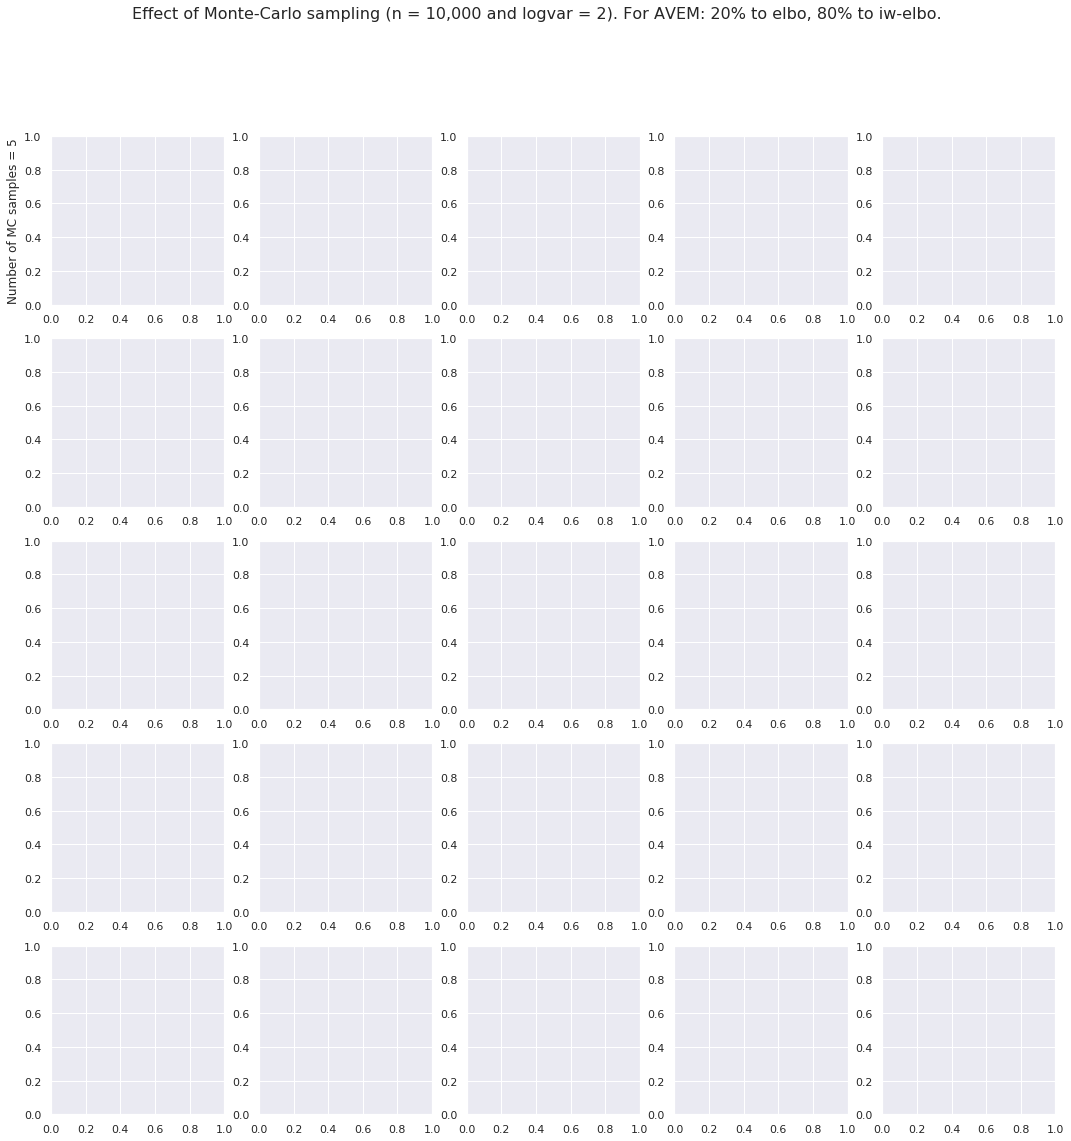

In [82]:

W_TRUE, B_TRUE, NONLINEARITY = (
 {0: [[3.0], [-2.0]],
  1: [[1.0, -1.0], [-3.0, -2.0]]},
 {0: [1.0, 3.0], 
  1: [1.0, 1.0]},
 'softplus')

@interact(
    epoch=IntSlider(min=0,max=299,step=5,value=0))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(18, 18))  
    fig.suptitle(
        'Effect of Monte-Carlo sampling (n = 10,000 and logvar = 2).'
        ' For AVEM: 20% to elbo, 80% to iw-elbo.', 
        fontsize=16)
   
    print_one_n_mc_row(axes, epoch, row_id=0, n_mc=5)
    print_one_n_mc_row(axes, epoch, row_id=1, n_mc=10)
    print_one_n_mc_row(axes, epoch, row_id=2, n_mc=20)
    print_one_n_mc_row(axes, epoch, row_id=3, n_mc=100)
    print_one_n_mc_row(axes, epoch, row_id=4, n_mc=200)
    
    sys.stdout = sys.__stdout__
    
    return epoch

In [83]:
def print_one_n_row(axes, epoch, row_id, n):
    output = '/scratch/users/nmiolane/toyoutput_logvarx_2_n_%d_n_mc_10_vem_02' % n
    crit_name = 'neg_elbo'
    
    ax = axes[row_id, 0]
    ax.set_ylabel('Number of samples n = %d' % n)
    
    print_row(axes, epoch, row_id, output)

In [84]:
def print_one_n_col(axes, epoch, col_id, n):
    output = '/scratch/users/nmiolane/toyoutput_logvarx_2_n_%d_n_mc_10_vem_02' % n
    crit_name = 'neg_elbo'
    
    ax = axes[0, col_id]
    ax.set_xlabel('Number of samples n = %d' % n)
    ax.xaxis.set_label_position('top') 
    
    print_col(axes, epoch, col_id, output)

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=5), Output()), _dom_classes=('widg…

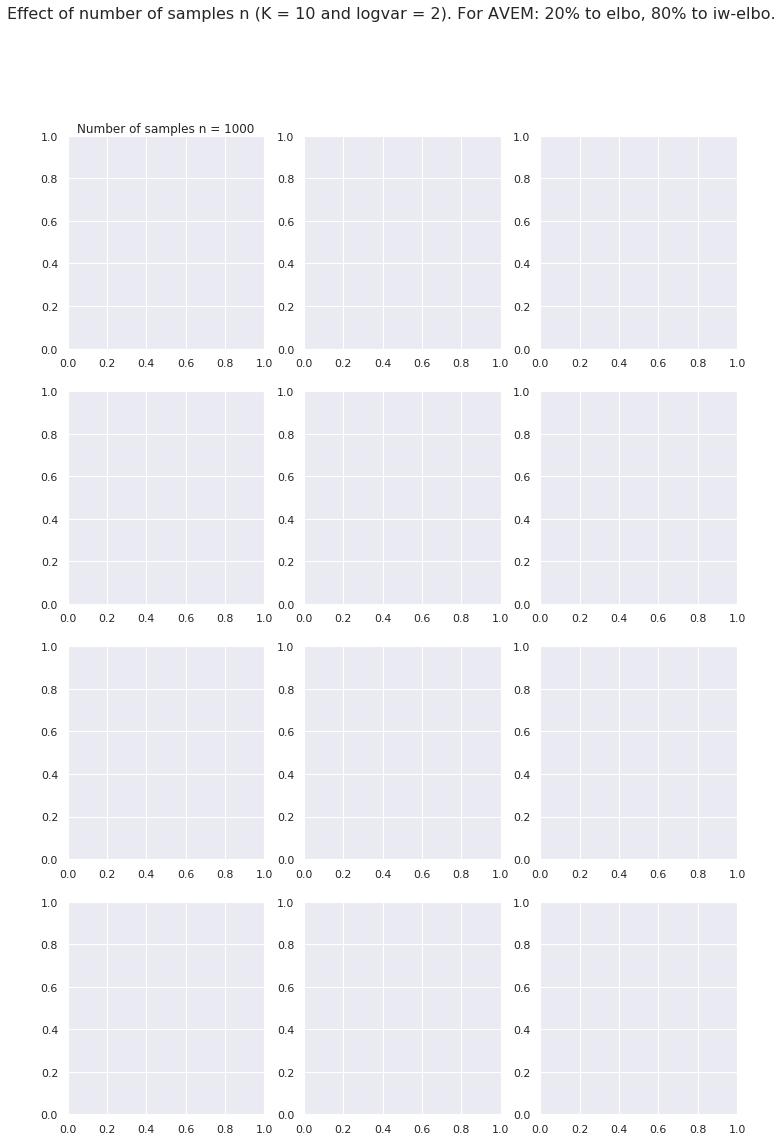

In [85]:
W_TRUE, B_TRUE, NONLINEARITY = (
 {0: [[3.0], [-2.0]],
  1: [[1.0, -1.0], [-3.0, -2.0]]},
 {0: [1.0, 3.0], 
  1: [1.0, 1.0]},
 'softplus')

@interact(
    epoch=IntSlider(min=0,max=299,step=5,value=0))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 18))  
    fig.suptitle(
        'Effect of number of samples n (K = 10 and logvar = 2).'
        ' For AVEM: 20% to elbo, 80% to iw-elbo.', 
        fontsize=16)
   
    print_one_n_col(axes, epoch, col_id=0, n=1000)
    print_one_n_col(axes, epoch, col_id=1, n=10000)
    print_one_n_col(axes, epoch, col_id=2, n=100000)

    sys.stdout = sys.__stdout__
    
    return epoch

interactive(children=(IntSlider(value=0, description='epoch', max=299, step=5), Output()), _dom_classes=('widg…

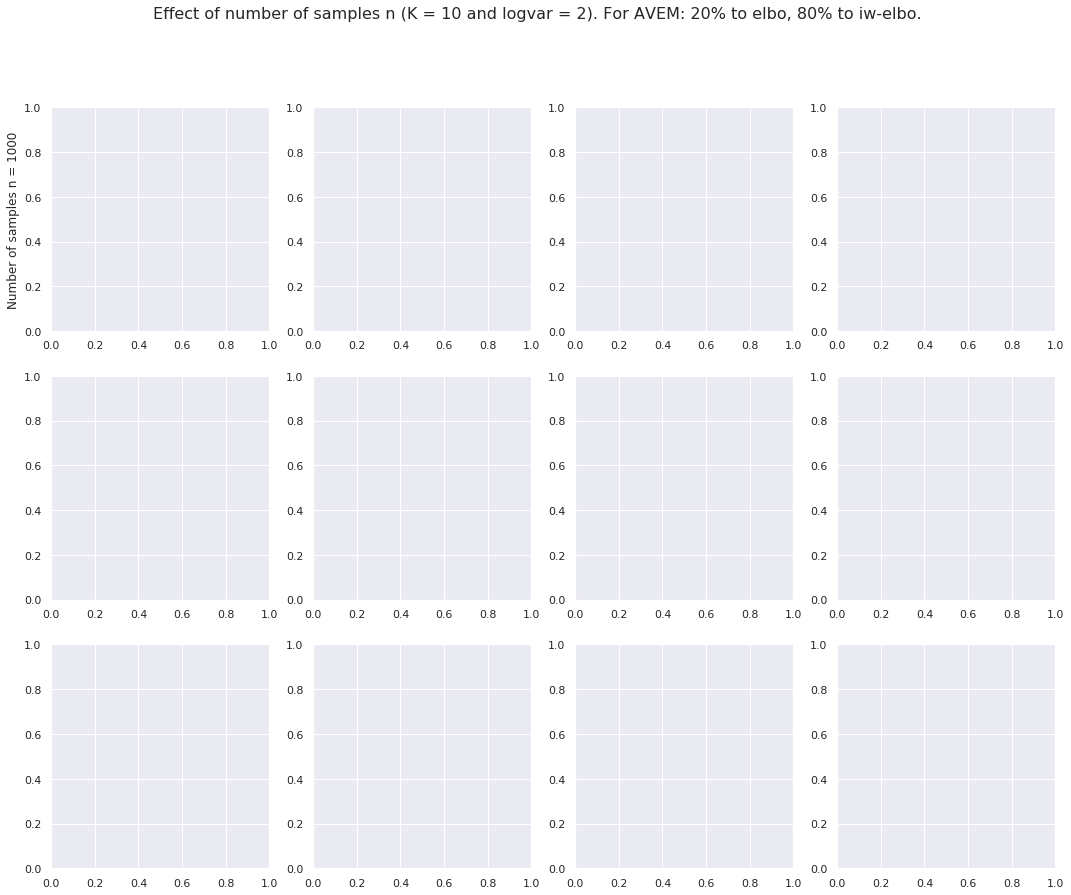

In [86]:
W_TRUE, B_TRUE, NONLINEARITY = (
 {0: [[3.0], [-2.0]],
  1: [[1.0, -1.0], [-3.0, -2.0]]},
 {0: [1.0, 3.0], 
  1: [1.0, 1.0]},
 'softplus')

@interact(
    epoch=IntSlider(min=0,max=299,step=5,value=0))
def display_training(epoch):
    sys.stdout = open(os.devnull, 'w')
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 14))  
    fig.suptitle(
        'Effect of number of samples n (K = 10 and logvar = 2).'
        ' For AVEM: 20% to elbo, 80% to iw-elbo.', 
        fontsize=16)
   
    print_one_n_row(axes, epoch, row_id=0, n=1000)
    print_one_n_row(axes, epoch, row_id=1, n=10000)
    print_one_n_row(axes, epoch, row_id=2, n=100000)

    sys.stdout = sys.__stdout__
    
    return epoch

# Look at more the $z_i$ given then $\tilde z_i$

To use the approximation of orthogonal projection, we need to show that $f_\theta(q_\phi(z_i|x_i))$ is centered around the orthogonal projection of $x_i$ on the current manifold characterized by $\theta$. (and that the variance of the approximated posterior is not too big).

We take the true generator, and the VAE. We take one point from the true generator and learn the $\mu, \sigma$ of the corresponding approximated posterior. We decode several samples and plot them in 2D.

In [83]:
def sample_from_posterior_on_manifold(output, epoch, algo_name, x, n_samples=30, manifold_name='r2'):
    decoder_vae = train_utils.load_module(
        output, algo_name=algo_name, module_name='decoder', epoch_id=epoch)
    encoder_vae = train_utils.load_module(
        output, algo_name=algo_name, module_name='encoder', epoch_id=epoch)
    
    mu, logvar = encoder_vae(x)
    sampled_z = toynn.reparametrize(mu, logvar, n_samples=n_samples)
    sampled_x, _ = decoder_vae(sampled_z)
    sampled_x = sampled_x.detach().cpu().numpy()
    if manifold_name != 'r2':
        sampled_x = toynn.convert_to_tangent_space(sampled_x, manifold_name=manifold_name)
        manifold, base_point = toynn.manifold_and_base_point(manifold_name)
        sampled_x = manifold.metric.exp(sampled_x, base_point=base_point)
        assert sampled_x.shape[1] == 3
    return sampled_x

def plot_posterior_on_manifold(ax, output, epoch, algo_name, x, n_samples=30, manifold_name='r2'):
    decoder = train_utils.load_module(
                 output, algo_name='vae', module_name='decoder', epoch_id=epoch)
    sampled_x = sample_from_posterior_on_manifold(
        output, epoch, algo_name, x, n_samples, manifold_name=manifold_name)
    
    ax = plot_submanifold_from_decoder(DECODER_TRUE, manifold_name, ax=ax, color='lime', s=20)
    ax = plot_submanifold_from_decoder(decoder, manifold_name, ax=ax, color='black', s=20)

    x = x.detach().cpu().numpy()
    if manifold_name != 'r2':
        x = toynn.convert_to_tangent_space(x, manifold_name=manifold_name)
        manifold, base_point = toynn.manifold_and_base_point(manifold_name)
        x = manifold.metric.exp(x, base_point=base_point)
    #sampled_x = sampled_x.detach().cpu().numpy()
    if manifold_name == 'r2':
        vis.plot_data(x, color='green', s=300, ax=ax)
        vis.plot_data(sampled_x, color=ALGO_COLOR_DICT[algo_name], s=100, ax=ax)
    elif manifold_name == 'h2':
        visualization.plot(x, ax=ax, space=VIS_DICT[manifold_name], color='green', alpha=1, s=300)
        visualization.plot(sampled_x, ax=ax, 
                           space=VIS_DICT[manifold_name], color=ALGO_COLOR_DICT[algo_name], alpha=1, s=100)
    else:
        ax.scatter(x[0], x[1], x[2], color='green', alpha=1, s=300)
        ax.scatter(sampled_x[:, 0], sampled_x[:, 1], sampled_x[:, 2], color=ALGO_COLOR_DICT[algo_name], alpha=1, s=300)
        
    return ax

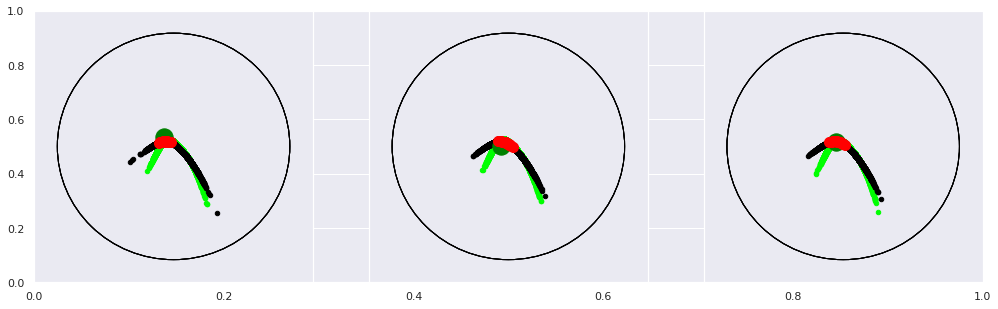

In [92]:
nrows = 1
ncols = 3
algo_names = ['vae'] #, 'iwae', 'vem', 'vem_02']

manifold_name = 'h2'

fig, axes = plt.subplots(figsize=(17, 5))
        
logvarx_true = -5
n = 100000
epoch = 100

output = get_toyoutput_manifold(manifold_name, logvarx_true, n)
decoder = train_utils.load_module(
                 output, algo_name='vae', module_name='decoder', epoch_id=epoch)

sys.stdout = open(os.devnull, 'w')

for j in range(ncols):
    x = toynn.generate_from_decoder(DECODER_TRUE)
    x = torch.Tensor(x).to(DEVICE)
    
    for i, algo_name in enumerate(algo_names):      
        ax = get_ax(fig, nrows, ncols, i, j, manifold_name=manifold_name, tangent_space='False')
        ax = plot_posterior_on_manifold(ax, output, epoch, algo_name, x, n_samples=30, manifold_name=manifold_name)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [157]:
@interact(
    w0_00=FloatSlider(min=-3,max=3,step=0.5,value=3), 
    w0_01=FloatSlider(min=-3,max=3,step=0.5,value=-2),
    b0_00=FloatSlider(min=-3,max=3,step=0.5,value=1),
    b0_01=FloatSlider(min=-3,max=3,step=0.5,value=3),
    w1_00=FloatSlider(min=-3,max=3,step=0.5,value=1), 
    w1_01=FloatSlider(min=-3,max=3,step=0.5,value=-1),
    w1_10=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w1_11=FloatSlider(min=-3,max=3,step=0.5,value=-2),
    b1_00=FloatSlider(min=-3,max=3,step=0.5,value=1),
    b1_01=FloatSlider(min=-3,max=3,step=0.5,value=1),
    w2_00=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w2_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    w2_10=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w2_11=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b2_00=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b2_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
        w3_00=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w3_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    w3_10=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w3_11=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b3_00=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b3_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
        w4_00=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w4_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    w4_10=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w4_11=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b4_00=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b4_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
        w5_00=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w5_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    w5_10=FloatSlider(min=-3,max=3,step=0.5,value=-3), 
    w5_11=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b5_00=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    b5_01=FloatSlider(min=-3,max=3,step=0.5,value=-3),
    nonlinearity=RadioButtons(
        options=[None, 'relu', 'softplus', 'tanh', 'sigmoid'],
        value='softplus',
        description='Non linearity:',
        disabled=False))
def display_data(w0_00, w0_01, b0_00, b0_01, 
                 w1_00, w1_01, w1_10, w1_11, b1_00, b1_01,
                 w2_00, w2_01, w2_10, w2_11, b2_00, b2_01, 
                 w3_00, w3_01, w3_10, w3_11, b3_00, b3_01, 
                 w4_00, w4_01, w4_10, w4_11, b4_00, b4_01, 
                 w5_00, w5_01, w5_10, w5_11, b5_00, b5_01, 
                 nonlinearity):
    W_TRUE = {}
    B_TRUE = {}

    W_TRUE[0] = [[w0_00], [w0_01]]
    B_TRUE[0] = [b0_00, b0_01]

    W_TRUE[1] = [[w1_00, w1_01], [w1_10, w1_11]]
    B_TRUE[1] = [b1_00, b1_01]
    
    W_TRUE[2] = [[w2_00, w2_01], [w2_10, w2_11]]
    B_TRUE[2] = [b2_00, b2_01]
    
    W_TRUE[3] = [[w3_00, w3_01], [w3_10, w3_11]]
    B_TRUE[3] = [b3_00, b3_01]
    # For the reconstruction
    W_TRUE[4] = [[w4_00, w4_01], [w4_10, w4_11]]
    B_TRUE[4] = [b4_00, b4_01]

    # For the logvarx
    W_TRUE[5] = [[w5_00, w5_01], [w5_10, w5_11]]
    B_TRUE[5] = [b5_00, b5_01]
    decoder_true = toynn.make_decoder_true(
        w_true=W_TRUE, b_true=B_TRUE, latent_dim=1, 
        data_dim=2, n_layers=5,
        nonlinearity=nonlinearity, with_biasx=True, with_logvarx=False)
    generated_true_x = toynn.generate_from_decoder(decoder_true, 300)
    
    W_TRUE[5] = [[-1000., -1000.], [-1000., -1000.]]
    B_TRUE[5] = [-1000., -1000.]
    decoder_true_novarx = toynn.make_decoder_true(
        w_true=W_TRUE, b_true=B_TRUE, latent_dim=1, 
        data_dim=2, n_layers=5,
        nonlinearity=nonlinearity, with_biasx=True, with_logvarx=True)
    generated_true_x_novarx = toynn.generate_from_decoder(decoder_true_novarx, 300)

    fig, ax = plt.subplots()
    ax = vis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)
    ax = vis.plot_data(generated_true_x_novarx, color='lime', label='from decoder true', ax=ax)

    ax.axis('equal')
    return W_TRUE, B_TRUE, nonlinearity

interactive(children=(FloatSlider(value=3.0, description='w0_00', max=3.0, min=-3.0, step=0.5), FloatSlider(va…

In [20]:
OUTPUT = '/scratch/users/nmiolane/toyoutput_5layers'

W_TRUE, B_TRUE, NONLINEARITY = ({0: [[3.0], [-3.0]],
  1: [[2.5, 0.0], [-3.0, -2.0]],
  2: [[-0.5, -1.5], [-1.5, 2.5]],
  3: [[1.5, 0.0], [-2.5, -1.5]],
  4: [[-2.5, 0.5], [0.5, -2.5]],
  5: [[-1000.0, -1000.0], [-1000.0, -1000.0]]},
 {0: [1.0, -2.5],
  1: [1.0, 2.0],
  2: [3.0, 3.0],
  3: [1.0, -1.0],
  4: [-2.0, -1.0],
  5: [-1000.0, -1000.0]},
 'softplus')

decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)
generated_true_x = toynn.generate_from_decoder(decoder_true, 300)

decoder_true_novarx = toynn.make_decoder_true(
        w_true=W_TRUE, b_true=B_TRUE, latent_dim=1, 
        data_dim=2, n_layers=5,
        nonlinearity=NONLINEARITY, with_biasx=True, with_logvarx=True)
generated_true_x_novarx = toynn.generate_from_decoder(decoder_true_novarx, 300)

@interact(
    epoch=FloatSlider(min=0,max=120,step=1,value=0))
def display_training(epoch):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
    
    algo_name = 'vae'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[0]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name, xlim=(-14, 5), ylim=(-10, 5))
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
    
    algo_name = 'iwae'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[1]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name)
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
          
    algo_name = 'vem'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[2]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name)    
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
    
    return epoch

interactive(children=(FloatSlider(value=0.0, description='epoch', max=120.0, step=1.0), Output()), _dom_classe…

# Same, with 100,000 samples generated instead of 10,000

In [27]:
OUTPUT = '/scratch/users/nmiolane/toyoutput_5layers_n100000'

W_TRUE, B_TRUE, NONLINEARITY = ({0: [[3.0], [-3.0]],
  1: [[2.5, 0.0], [-3.0, -2.0]],
  2: [[-0.5, -1.5], [-1.5, 2.5]],
  3: [[1.5, 0.0], [-2.5, -1.5]],
  4: [[-2.5, 0.5], [0.5, -2.5]],
  5: [[-1000.0, -1000.0], [-1000.0, -1000.0]]},
 {0: [1.0, -2.5],
  1: [1.0, 2.0],
  2: [3.0, 3.0],
  3: [1.0, -1.0],
  4: [-2.0, -1.0],
  5: [-1000.0, -1000.0]},
 'softplus')

decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)
generated_true_x = toynn.generate_from_decoder(decoder_true, 300)


decoder_true_novarx = toynn.make_decoder_true(
        w_true=W_TRUE, b_true=B_TRUE, latent_dim=1, 
        data_dim=2, n_layers=5,
        nonlinearity=NONLINEARITY, with_biasx=True, with_logvarx=True)
generated_true_x_novarx = toynn.generate_from_decoder(decoder_true_novarx, 300)

@interact(
    epoch=FloatSlider(min=0,max=79,step=1,value=0))
def display_training(epoch):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
    
    algo_name = 'vae'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[0]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name, xlim=(-14, 5), ylim=(-10, 5))
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
    
    algo_name = 'iwae'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[1]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name)
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
          
    algo_name = 'vem'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[2]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name)    
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
    
    return epoch

interactive(children=(FloatSlider(value=0.0, description='epoch', max=79.0, step=1.0), Output()), _dom_classes…

# With logvarz and biasz, 10000

In [32]:
OUTPUT = '/scratch/users/nmiolane/toyoutput'

W_TRUE, B_TRUE, NONLINEARITY = ({0: [[3.0], [-3.0]],
  1: [[2.5, 0.0], [-3.0, -2.0]],
  2: [[-0.5, -1.5], [-1.5, 2.5]],
  3: [[1.5, 0.0], [-2.5, -1.5]],
  4: [[-2.5, 0.5], [0.5, -2.5]],
  5: [[-1000.0, -1000.0], [-1000.0, -1000.0]]},
 {0: [1.0, -2.5],
  1: [1.0, 2.0],
  2: [3.0, 3.0],
  3: [1.0, -1.0],
  4: [-2.0, -1.0],
  5: [-1000.0, -1000.0]},
 'softplus')

decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)
generated_true_x = toynn.generate_from_decoder(decoder_true, 300)


decoder_true_novarx = toynn.make_decoder_true(
        w_true=W_TRUE, b_true=B_TRUE, latent_dim=1, 
        data_dim=2, n_layers=5,
        nonlinearity=NONLINEARITY, with_biasx=True, with_logvarx=True)
generated_true_x_novarx = toynn.generate_from_decoder(decoder_true_novarx, 300)

@interact(
    epoch=FloatSlider(min=0,max=79,step=1,value=0))
def display_training(epoch):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
    
    algo_name = 'vae'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[0]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name, xlim=(-14, 5), ylim=(-10, 5))
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
    
    algo_name = 'iwae'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[1]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name)
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
          
    algo_name = 'vem'
    generated_x, generated_x_novarx, train_losses_total, val_losses_total = get_training_data(
        algo_name, epoch)
    ax = axes[2]
    ax = plot_points(ax, generated_x, generated_x_novarx, algo_name)    
    ax = axes[3]
    ax = plot_losses(ax, train_losses_total, val_losses_total, algo_name)
    
    return epoch

interactive(children=(FloatSlider(value=0.0, description='epoch', max=79.0, step=1.0), Output()), _dom_classes…

interactive(children=(FloatSlider(value=0.0, description='epoch', max=79.0, step=1.0), Output()), _dom_classes…

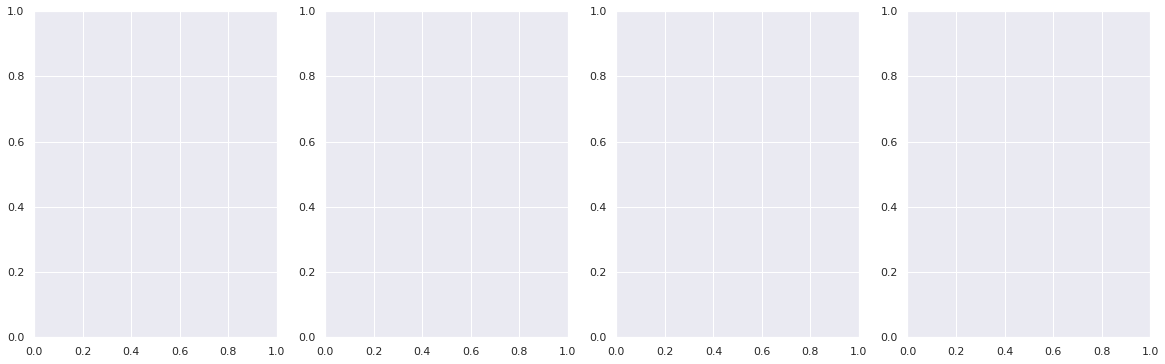

In [88]:
OUTPUT = '/scratch/users/nmiolane/toyoutput_2layers'

W_TRUE, B_TRUE, NONLINEARITY = ({0: [[3.0], [-2.0]],
  1: [[1.0, -1.0], [-3.0, -2.0]],
  2: [[-3.0, -3.0], [-3.0, -3.0]]},
 {0: [1.0, 3.0], 1: [1.0, 1.0], 2: [-3.0, -3.0]},
 'softplus')


@interact(
    epoch=FloatSlider(min=0,max=79,step=1,value=0))
def display_training(epoch):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
    
    algo_name = 'iwae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        OUTPUT, algo_name, epoch)
    ax = axes[0]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[3]
    ax = plot_losses(ax, train_losses, val_losses, algo_name)
    
    algo_name = 'iwae'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        OUTPUT, algo_name, epoch)
    ax = axes[1]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[3]
    ax = plot_losses(ax, train_losses, val_losses, algo_name)
          
    algo_name = 'vem'
    gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, train_losses, val_losses = vis.get_training_data(
        OUTPUT, algo_name, epoch)
    ax = axes[2]
    ax = vis.plot_submanifolds(ax, epoch, gen_true_x, gen_true_x_novarx, gen_x, gen_x_novarx, algo_name)
    ax = axes[3]
    ax = plot_losses(ax, train_losses, val_losses, algo_name)
    
    return epoch

In [ ]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
fig.suptitle(
            '%s: Looking at f_theta(q_\phi),'
            ' for logvar = 2, K = 10, and n = 10000.' % 'VAE', fontsize=16)

def on_button_clicked(b, ax):
    #with output:
        decoder_true = torch.load(os.path.join(OUTPUT, 'synthetic/decoder_true.pth'), map_location=DEVICE)
        x = toynn.generate_from_decoder(decoder_true)
        x = torch.Tensor(x).to(DEVICE)



        output = '/scratch/users/nmiolane/toyoutput_n_mc_10_n_10000'
        epoch = 299

        ax = plot_posterior_on_manifold(ax, output, epoch, algo_name, x, n_samples=30)

button.on_click(on_button_clicked(button, ax))